In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os, sys
from pathlib import Path
from math import floor
from random import randrange, random
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from ML.dataset import PMUAngleDataset
from ML.models import TabLSTM, CNN, SensorRNN
from ML.transforms import *
from ML.trainer import SensorTrainer

In [2]:
%%capture
import torch.backends.cudnn as cudnn
torch.cuda.empty_cache()
cudnn.benchmark = True  # Optimise for hardware

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bs = 64
# sensor_num = 4
# scada_size = 2
sensor_num = 21
scada_size = 14

In [3]:
awgn = AWGN(60)
x1rescale = RescalePMU([-180, 49.5, 0, -180, 49.5, 0], [180, 50.5, 240, 180, 50.5, 240], sensor_num)
cut_time = CutoutTime(.3, 5)

x2rescale = Rescale(0, 240)
yrescale = Rescale(-180., 180.)

x1tfms = transforms.Compose([awgn, x1rescale])

In [4]:
scadapath = "2_load_scadadata"
datapath = "2_load_data"

In [5]:
noaug_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type=None),
    PMUAngleDataset(scadapath, datapath, x1tfms=transforms.Compose([x1rescale]), x2tfms=x2rescale, ytfms=yrescale),
    device
)

cut_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type=None),
    PMUAngleDataset(scadapath, datapath, x1tfms=transforms.Compose([x1rescale, cut_time]), x2tfms=x2rescale, ytfms=yrescale),
    device
)

gru_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type=None),
    PMUAngleDataset(scadapath, datapath, x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

lstm_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type=None, rnn_type="lstm"),
    PMUAngleDataset(scadapath, datapath, x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

cnn_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="cnn"),
    PMUAngleDataset(scadapath, datapath, x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

resnet_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="resnet"),
    PMUAngleDataset(scadapath, datapath, x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

attn_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="resnet", attention=True),
    PMUAngleDataset(scadapath, datapath, x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

In [4]:
epochs = 150

noaug_results = noaug_test(epochs)
cut_results = cut_test(epochs)
gru_results = gru_test(epochs)
lstm_results = lstm_test(epochs)
cnn_results = cnn_test(epochs)
resnet_results = resnet_test(epochs)
attn_results = attn_test(epochs)

NameError: name 'noaug_test' is not defined

In [6]:
sensor_num = 21
scada_size = 14
large_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="resnet", attention=True, num_layers=4),
    PMUAngleDataset("./scadadata", "./data", x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale),
    device
)

In [7]:
epochs = 150
large_results = large_test(epochs)


Epoch: 1/150, Training Loss: 0.237552, L2 Loss: 0.273113, L1 Loss: 0.449283,
Ang Err Degrees: 80.8710, Ang Err Rads: 1.4115
Breakdown: [  5.203725  22.427555  32.912933  36.448162  60.441677  35.818684
  73.60294   88.76289  114.799706 118.37795  132.74588  112.85187
 139.37456  158.50748 ]
--------------------



Epoch: 2/150, Training Loss: 0.199749, L2 Loss: 0.219374, L1 Loss: 0.391012,
Ang Err Degrees: 70.3821, Ang Err Rads: 1.2284
Breakdown: [  5.203725  33.0885    31.177702  17.949366  55.872772  43.887737
  52.966145  47.527042 114.799706  92.114136 136.85414   77.48086
 118.13873  158.4853  ]
--------------------



Epoch: 3/150, Training Loss: 0.175816, L2 Loss: 0.172644, L1 Loss: 0.321499,
Ang Err Degrees: 57.8699, Ang Err Rads: 1.0100
Breakdown: [ 13.933347  29.825647  39.337635  23.968523  38.459583  24.969542
  27.259424  56.17268   98.18807   60.302082  93.70406   75.674446
 105.426796 129.99454 ]
--------------------



Epoch: 4/150, Training Loss: 0.170129, L2 Loss: 0.144418, L1 Loss: 0.277453,
Ang Err Degrees: 49.9416, Ang Err Rads: 0.8716
Breakdown: [17.232695 23.110922 41.281307 37.68083  58.236927 19.515413 30.026411
 54.36622  54.538326 50.44541  82.31923  72.52207  89.72507  79.53621 ]
--------------------



Epoch: 5/150, Training Loss: 0.157980, L2 Loss: 0.128370, L1 Loss: 0.265452,
Ang Err Degrees: 47.7814, Ang Err Rads: 0.8339
Breakdown: [ 5.990791 18.30968  29.823236 33.409077 60.27409  29.0994   32.510998
 48.496178 51.233814 55.26919  67.5941   77.67401  90.74914  69.27481 ]
--------------------



Epoch: 6/150, Training Loss: 0.151174, L2 Loss: 0.121215, L1 Loss: 0.254963,
Ang Err Degrees: 45.8933, Ang Err Rads: 0.8010
Breakdown: [ 6.0008955 14.157648  33.142513  31.914518  45.23436   31.438192
 33.249336  46.210304  51.029156  46.406067  68.838394  72.55877
 85.1527    77.99851  ]
--------------------



Epoch: 7/150, Training Loss: 0.147874, L2 Loss: 0.131696, L1 Loss: 0.261570,
Ang Err Degrees: 47.0825, Ang Err Rads: 0.8217
Breakdown: [ 9.933128 13.952494 34.558613 23.04915  43.870014 33.96048  27.697962
 42.173603 48.894775 53.757446 74.49976  74.12005  92.863075 90.44158 ]
--------------------



Epoch: 8/150, Training Loss: 0.147558, L2 Loss: 0.120853, L1 Loss: 0.245500,
Ang Err Degrees: 44.1899, Ang Err Rads: 0.7713
Breakdown: [ 9.480564 11.053325 33.08854  25.557455 43.571346 29.86333  27.781012
 43.58662  46.450897 50.34477  65.118286 71.080055 85.90567  79.500336]
--------------------



Epoch: 9/150, Training Loss: 0.138123, L2 Loss: 0.119750, L1 Loss: 0.245893,
Ang Err Degrees: 44.2608, Ang Err Rads: 0.7725
Breakdown: [ 6.0018573 10.178031  28.79827   24.563648  42.833176  27.581491
 26.121597  41.50422   45.40096   51.304226  70.524155  73.38807
 87.2044    85.08178  ]
--------------------



Epoch: 10/150, Training Loss: 0.139528, L2 Loss: 0.117163, L1 Loss: 0.244188,
Ang Err Degrees: 43.9538, Ang Err Rads: 0.7671
Breakdown: [ 6.901854 10.809287 34.244972 30.149717 42.29792  26.865788 30.317871
 44.56362  46.19108  48.545723 63.43577  71.451164 83.30602  77.21255 ]
--------------------



Epoch: 11/150, Training Loss: 0.138072, L2 Loss: 0.121158, L1 Loss: 0.232805,
Ang Err Degrees: 41.9048, Ang Err Rads: 0.7314
Breakdown: [15.303861 11.525361 27.13013  26.410627 46.627357 23.034275 25.551458
 54.463448 39.55179  46.464493 60.175503 69.62272  81.85877  68.888985]
--------------------



Epoch: 12/150, Training Loss: 0.136171, L2 Loss: 0.151622, L1 Loss: 0.265110,
Ang Err Degrees: 47.7199, Ang Err Rads: 0.8329
Breakdown: [27.568869 14.783106 41.873737 24.287857 48.079693 19.91583  29.863901
 49.113735 49.435925 59.97055  62.891872 78.78013  92.71358  90.83878 ]
--------------------



Epoch: 13/150, Training Loss: 0.131749, L2 Loss: 0.122217, L1 Loss: 0.237286,
Ang Err Degrees: 42.7116, Ang Err Rads: 0.7455
Breakdown: [11.220232  9.404319 23.326664 22.60505  37.197388 28.188583 31.219938
 44.46026  44.929226 50.99273  62.555172 72.78234  86.513054 78.21296 ]
--------------------



Epoch: 14/150, Training Loss: 0.129664, L2 Loss: 0.112529, L1 Loss: 0.231941,
Ang Err Degrees: 41.7493, Ang Err Rads: 0.7287
Breakdown: [ 7.500671 10.813454 22.81416  23.327396 38.736897 17.783073 29.308598
 49.41993  44.63445  50.084663 57.40109  70.10011  86.25832  78.24176 ]
--------------------



Epoch: 15/150, Training Loss: 0.126171, L2 Loss: 0.110083, L1 Loss: 0.220736,
Ang Err Degrees: 39.7324, Ang Err Rads: 0.6935
Breakdown: [ 5.97092   6.172818 17.393875 23.307585 36.279964 17.552067 25.99343
 39.583855 40.947834 45.68481  67.4049   68.44052  81.55932  80.79647 ]
--------------------



Epoch: 16/150, Training Loss: 0.125416, L2 Loss: 0.106193, L1 Loss: 0.218088,
Ang Err Degrees: 39.2559, Ang Err Rads: 0.6851
Breakdown: [ 6.0021377  7.1403604 17.429352  23.048262  37.454735  16.543476
 26.206196  45.620796  40.42815   45.17976   61.304115  68.049225
 80.20236   75.80868  ]
--------------------



Epoch: 17/150, Training Loss: 0.124243, L2 Loss: 0.110740, L1 Loss: 0.219841,
Ang Err Degrees: 39.5713, Ang Err Rads: 0.6906
Breakdown: [ 6.0021     6.4303255 15.694058  20.997229  29.85242   21.130318
 26.008802  43.023182  39.92108   45.351757  70.32685   66.01766
 79.44351   84.63345  ]
--------------------



Epoch: 18/150, Training Loss: 0.125361, L2 Loss: 0.116647, L1 Loss: 0.225376,
Ang Err Degrees: 40.5677, Ang Err Rads: 0.7080
Breakdown: [12.420522  9.436745 22.277922 23.848259 38.429462 19.511198 27.64916
 49.301636 41.86512  47.42108  61.157787 64.02116  80.93324  77.38212 ]
--------------------



Epoch: 19/150, Training Loss: 0.125699, L2 Loss: 0.120308, L1 Loss: 0.220456,
Ang Err Degrees: 39.6820, Ang Err Rads: 0.6926
Breakdown: [14.830159  7.920186 23.301552 20.299393 36.424557 18.00656  25.665197
 44.257137 38.625618 42.623146 70.01621  63.357533 75.9527   83.31242 ]
--------------------



Epoch: 20/150, Training Loss: 0.122949, L2 Loss: 0.105911, L1 Loss: 0.210943,
Ang Err Degrees: 37.9698, Ang Err Rads: 0.6627
Breakdown: [10.456386  8.341311 17.092375 19.865858 39.744152 13.966425 26.579828
 54.989796 36.7176   44.461098 52.615303 62.653595 74.3363   74.83325 ]
--------------------



Epoch: 21/150, Training Loss: 0.120573, L2 Loss: 0.106605, L1 Loss: 0.207197,
Ang Err Degrees: 37.2955, Ang Err Rads: 0.6509
Breakdown: [ 9.586843  4.551543 18.334232 17.895653 33.971825 17.079456 26.309431
 46.191097 37.171528 45.01483  57.179867 62.29568  76.60353  73.549614]
--------------------



Epoch: 22/150, Training Loss: 0.119484, L2 Loss: 0.103269, L1 Loss: 0.202452,
Ang Err Degrees: 36.4414, Ang Err Rads: 0.6360
Breakdown: [ 7.9051323  5.8773713 15.843927  17.91564   31.772871  18.995594
 26.294209  46.607605  36.48387   40.76886   54.498486  63.565746
 76.073364  69.17844  ]
--------------------



Epoch: 23/150, Training Loss: 0.119925, L2 Loss: 0.099172, L1 Loss: 0.200093,
Ang Err Degrees: 36.0168, Ang Err Rads: 0.6286
Breakdown: [ 6.2115383  4.7356634 12.883987  18.351477  33.354305  17.8108
 26.887548  50.383823  36.6888    41.997505  52.1789    61.484425
 74.95043   67.14498  ]
--------------------



Epoch: 24/150, Training Loss: 0.120220, L2 Loss: 0.101618, L1 Loss: 0.208794,
Ang Err Degrees: 37.5828, Ang Err Rads: 0.6559
Breakdown: [ 5.990614  6.422612 13.661249 18.543247 33.954082 16.899101 27.525349
 51.68899  37.85745  42.469616 62.831215 60.520782 74.755936 73.87388 ]
--------------------



Epoch: 25/150, Training Loss: 0.119126, L2 Loss: 0.103961, L1 Loss: 0.217586,
Ang Err Degrees: 39.1655, Ang Err Rads: 0.6836
Breakdown: [ 9.268237  7.049581 18.241585 15.170531 37.275814 24.638357 29.068563
 58.32989  40.815258 45.88873  57.13389  62.398193 77.27868  68.58399 ]
--------------------



Epoch: 26/150, Training Loss: 0.117222, L2 Loss: 0.101377, L1 Loss: 0.205760,
Ang Err Degrees: 37.0368, Ang Err Rads: 0.6464
Breakdown: [ 5.9838233  4.5642366 12.395714  17.18654   32.719433  17.223652
 27.649769  51.461384  37.354645  41.44515   62.628204  60.099243
 73.55286   75.07769  ]
--------------------



Epoch: 27/150, Training Loss: 0.117401, L2 Loss: 0.101163, L1 Loss: 0.201588,
Ang Err Degrees: 36.2858, Ang Err Rads: 0.6333
Breakdown: [ 6.0015025  4.2316794 13.630374  17.751211  30.430008  16.067719
 27.68584   47.570778  36.66068   39.34205   60.33108   59.595375
 74.17914   75.34233  ]
--------------------



Epoch: 28/150, Training Loss: 0.115684, L2 Loss: 0.097659, L1 Loss: 0.201497,
Ang Err Degrees: 36.2694, Ang Err Rads: 0.6330
Breakdown: [ 6.001735   3.9384549 12.65079   16.819422  34.2147    14.8392
 27.95817   54.800312  37.7046    41.236843  54.042     61.432705
 74.06919   68.88273  ]
--------------------



Epoch: 29/150, Training Loss: 0.113236, L2 Loss: 0.097298, L1 Loss: 0.202857,
Ang Err Degrees: 36.5142, Ang Err Rads: 0.6373
Breakdown: [ 6.3197126  4.0709796 13.075858  16.358633  36.937183  14.646263
 27.65534   56.4871    37.31822   42.94898   51.345295  62.114777
 73.72488   69.01249  ]
--------------------



Epoch: 30/150, Training Loss: 0.113734, L2 Loss: 0.102727, L1 Loss: 0.201983,
Ang Err Degrees: 36.3569, Ang Err Rads: 0.6345
Breakdown: [ 9.955034   4.1838737 16.020977  17.54128   35.012768  13.5440855
 24.898092  52.733875  35.180565  41.449203  56.902172  60.57422
 71.59209   73.92598  ]
--------------------



Epoch: 31/150, Training Loss: 0.113789, L2 Loss: 0.101165, L1 Loss: 0.201820,
Ang Err Degrees: 36.3276, Ang Err Rads: 0.6340
Breakdown: [ 9.036667  5.150383 14.985634 16.575882 35.516785 12.388544 25.41776
 53.76399  36.238354 41.48486  55.966335 59.87442  72.62906  72.68871 ]
--------------------



Epoch: 32/150, Training Loss: 0.114569, L2 Loss: 0.096442, L1 Loss: 0.197245,
Ang Err Degrees: 35.5040, Ang Err Rads: 0.6197
Breakdown: [ 6.0017505  4.185539  11.616663  16.83508   34.5093    13.568606
 26.194822  53.331367  35.586315  41.190716  53.654377  59.811775
 72.787125  68.59298  ]
--------------------



Epoch: 33/150, Training Loss: 0.112891, L2 Loss: 0.096776, L1 Loss: 0.203297,
Ang Err Degrees: 36.5935, Ang Err Rads: 0.6387
Breakdown: [ 6.001771  4.272365 11.397324 15.637566 37.03553  14.848311 27.069244
 59.615234 36.68536  42.416485 54.986755 60.106415 73.8319   69.20335 ]
--------------------



Epoch: 34/150, Training Loss: 0.112758, L2 Loss: 0.099165, L1 Loss: 0.200621,
Ang Err Degrees: 36.1118, Ang Err Rads: 0.6303
Breakdown: [ 6.00171    4.3644156 12.484601  15.526453  32.067642  11.658129
 26.946974  51.44601   37.703648  41.854618  61.070843  58.927807
 73.10839   73.195656 ]
--------------------



Epoch: 35/150, Training Loss: 0.111435, L2 Loss: 0.095133, L1 Loss: 0.197159,
Ang Err Degrees: 35.4886, Ang Err Rads: 0.6194
Breakdown: [ 6.0020084  4.924508  11.614053  16.775572  35.232616  10.428775
 26.358381  55.3138    37.60413   41.492405  50.986618  60.459286
 72.70887   67.73931  ]
--------------------



Epoch: 36/150, Training Loss: 0.113204, L2 Loss: 0.104666, L1 Loss: 0.212160,
Ang Err Degrees: 38.1889, Ang Err Rads: 0.6665
Breakdown: [10.021352  6.891019 15.019155 14.46995  36.347515 11.65852  28.553656
 58.466    39.288097 48.030964 54.20976  66.04091  78.683495 71.76365 ]
--------------------



Epoch: 37/150, Training Loss: 0.110828, L2 Loss: 0.098983, L1 Loss: 0.196546,
Ang Err Degrees: 35.3784, Ang Err Rads: 0.6175
Breakdown: [ 9.726313   3.8176174 13.912058  15.267776  34.36098   13.487818
 25.30643   54.53893   34.92348   39.601837  54.84905   59.256763
 70.61468   68.725296 ]
--------------------



Epoch: 38/150, Training Loss: 0.110463, L2 Loss: 0.098440, L1 Loss: 0.194578,
Ang Err Degrees: 35.0240, Ang Err Rads: 0.6113
Breakdown: [ 8.603648   4.0311713 16.533384  14.416817  32.832516  13.913663
 25.878576  49.681423  35.577084  38.5615    56.11606   57.34679
 69.365005  70.05376  ]
--------------------



Epoch: 39/150, Training Loss: 0.109534, L2 Loss: 0.094447, L1 Loss: 0.191323,
Ang Err Degrees: 34.4381, Ang Err Rads: 0.6011
Breakdown: [ 6.5054293  3.8954606 16.35349   15.284251  34.321335  13.501269
 26.210226  50.9399    36.031593  38.055866  51.398598  57.21473
 68.86512   64.20644  ]
--------------------



Epoch: 40/150, Training Loss: 0.108805, L2 Loss: 0.093732, L1 Loss: 0.193812,
Ang Err Degrees: 34.8861, Ang Err Rads: 0.6089
Breakdown: [ 6.0010653  3.9897811 11.400328  15.930534  35.373417  12.509078
 26.306961  54.634396  35.809277  39.699062  53.519817  58.3803
 69.16921   66.30475  ]
--------------------



Epoch: 41/150, Training Loss: 0.108455, L2 Loss: 0.094558, L1 Loss: 0.194447,
Ang Err Degrees: 35.0005, Ang Err Rads: 0.6109
Breakdown: [ 5.9921346  3.9962754 12.003551  15.473116  34.33404   12.677131
 26.22178   54.850597  35.829567  39.65257   54.77148   58.392574
 69.08337   67.24365  ]
--------------------



Epoch: 42/150, Training Loss: 0.108065, L2 Loss: 0.094832, L1 Loss: 0.195493,
Ang Err Degrees: 35.1888, Ang Err Rads: 0.6142
Breakdown: [ 6.001542   4.0259843 13.808234  15.413608  35.03286   12.083763
 26.194426  53.927197  35.71191   40.06562   55.484993  58.050213
 69.41805   67.94114  ]
--------------------



Epoch: 43/150, Training Loss: 0.107240, L2 Loss: 0.094903, L1 Loss: 0.195867,
Ang Err Degrees: 35.2560, Ang Err Rads: 0.6153
Breakdown: [ 5.9877143  3.9704282 17.37557   15.217761  33.694057  12.748425
 26.102295  52.485725  36.413555  40.80425   54.30862   57.881832
 69.305176  67.80384  ]
--------------------



Epoch: 44/150, Training Loss: 0.108965, L2 Loss: 0.096022, L1 Loss: 0.195308,
Ang Err Degrees: 35.1554, Ang Err Rads: 0.6136
Breakdown: [ 5.9727845  4.0567183 18.631884  15.726709  32.772625  12.021309
 25.83139   49.151817  36.624355  39.583508  57.231426  56.62942
 68.99612   69.461876 ]
--------------------



Epoch: 45/150, Training Loss: 0.107062, L2 Loss: 0.094651, L1 Loss: 0.192369,
Ang Err Degrees: 34.6263, Ang Err Rads: 0.6043
Breakdown: [ 5.972149   3.8604562 20.05512   15.272298  32.740444  11.923247
 26.189367  50.11437   37.02651   38.628456  52.50226   56.52769
 69.08461   65.3868   ]
--------------------



Epoch: 46/150, Training Loss: 0.107536, L2 Loss: 0.091750, L1 Loss: 0.188571,
Ang Err Degrees: 33.9429, Ang Err Rads: 0.5924
Breakdown: [ 5.9882207  3.9665306 17.74386   15.181879  34.851315  11.127494
 26.221231  52.830288  36.144917  37.358456  47.888683  55.86445
 67.90825   62.63968  ]
--------------------



Epoch: 47/150, Training Loss: 0.107679, L2 Loss: 0.094815, L1 Loss: 0.193355,
Ang Err Degrees: 34.8039, Ang Err Rads: 0.6074
Breakdown: [10.01886    5.0991197 15.002298  15.20495   37.1946    10.693621
 26.228992  54.06027   36.251556  38.78052   50.494522  54.16937
 70.29674   66.883736 ]
--------------------



Epoch: 48/150, Training Loss: 0.107927, L2 Loss: 0.094401, L1 Loss: 0.193304,
Ang Err Degrees: 34.7948, Ang Err Rads: 0.6073
Breakdown: [ 7.5184226  4.6277575 14.131099  15.367454  36.33129   11.698996
 26.366993  53.93107   36.551895  38.92553   52.06242   55.52533
 69.42342   66.052315 ]
--------------------



Epoch: 49/150, Training Loss: 0.108557, L2 Loss: 0.094810, L1 Loss: 0.194796,
Ang Err Degrees: 35.0632, Ang Err Rads: 0.6120
Breakdown: [ 6.001796   5.2372956 14.47334   14.138059  34.36672   10.936858
 26.722815  53.20764   35.935726  40.458054  54.63583   58.57972
 69.20233   67.50515  ]
--------------------



Epoch: 50/150, Training Loss: 0.107853, L2 Loss: 0.095268, L1 Loss: 0.192597,
Ang Err Degrees: 34.6675, Ang Err Rads: 0.6051
Breakdown: [ 6.0018034  4.8392687 16.25546   15.264978  32.95816    9.782646
 26.122574  49.684387  35.15472   39.741352  56.998627  56.50434
 67.896194  68.65626  ]
--------------------



Epoch: 51/150, Training Loss: 0.108071, L2 Loss: 0.093237, L1 Loss: 0.189844,
Ang Err Degrees: 34.1720, Ang Err Rads: 0.5964
Breakdown: [ 5.9874907  4.017591  17.152586  14.796935  34.33564   10.301848
 26.299433  50.95309   35.88443   38.49016   52.138714  56.110706
 67.68611   64.76929  ]
--------------------



Epoch: 52/150, Training Loss: 0.105702, L2 Loss: 0.090599, L1 Loss: 0.188064,
Ang Err Degrees: 33.8516, Ang Err Rads: 0.5908
Breakdown: [ 8.339652  4.273034 12.860839 14.360633 37.796497 12.195468 25.598661
 57.454987 35.08249  36.64559  46.6087   55.386738 68.13607  61.16952 ]
--------------------



Epoch: 53/150, Training Loss: 0.106166, L2 Loss: 0.094862, L1 Loss: 0.192007,
Ang Err Degrees: 34.5613, Ang Err Rads: 0.6032
Breakdown: [ 8.352527  4.145069 12.072334 14.465894 36.01156  11.828735 25.267017
 54.225594 34.742874 37.24554  56.64933  54.89181  67.36132  68.571815]
--------------------



Epoch: 54/150, Training Loss: 0.107396, L2 Loss: 0.093990, L1 Loss: 0.193171,
Ang Err Degrees: 34.7708, Ang Err Rads: 0.6069
Breakdown: [ 6.1581073  3.9414685 14.005971  13.923182  35.523758  10.6295805
 26.595694  54.66794   35.904037  39.752834  54.433266  57.380642
 67.809395  66.57721  ]
--------------------



Epoch: 55/150, Training Loss: 0.105163, L2 Loss: 0.093651, L1 Loss: 0.190975,
Ang Err Degrees: 34.3755, Ang Err Rads: 0.6000
Breakdown: [ 7.7307205  4.066346  12.779488  14.504361  35.538918  11.404239
 25.663153  53.595947  34.728966  38.074768  54.709938  54.875683
 66.89938   67.697395 ]
--------------------



Epoch: 56/150, Training Loss: 0.105070, L2 Loss: 0.092853, L1 Loss: 0.188993,
Ang Err Degrees: 34.0187, Ang Err Rads: 0.5937
Breakdown: [ 5.99984   3.874546 14.158997 15.050987 34.793423  9.912368 25.976194
 53.206512 35.329945 38.57411  52.65791  55.72645  66.46084  65.05415 ]
--------------------



Epoch: 57/150, Training Loss: 0.105928, L2 Loss: 0.091545, L1 Loss: 0.188850,
Ang Err Degrees: 33.9929, Ang Err Rads: 0.5933
Breakdown: [ 5.9973226  3.7607033 13.657428  14.237439  35.43792    9.960179
 26.610596  54.83512   36.639004  38.34234   49.654446  56.520885
 67.52321   63.23836  ]
--------------------



Epoch: 58/150, Training Loss: 0.104532, L2 Loss: 0.094139, L1 Loss: 0.191752,
Ang Err Degrees: 34.5154, Ang Err Rads: 0.6024
Breakdown: [ 8.038358   3.8549893 14.355891  13.621112  34.867023  10.792956
 25.848099  54.150494  36.10619   38.63881   52.95997   56.49513
 67.93206   66.931816 ]
--------------------



Epoch: 59/150, Training Loss: 0.104704, L2 Loss: 0.093467, L1 Loss: 0.189117,
Ang Err Degrees: 34.0411, Ang Err Rads: 0.5941
Breakdown: [ 8.043427   3.9086118 14.150644  13.809321  34.35681   10.699725
 25.481058  51.831818  34.93538   38.22735   53.000454  55.47176
 66.99309   67.04603  ]
--------------------



Epoch: 60/150, Training Loss: 0.105599, L2 Loss: 0.093868, L1 Loss: 0.190408,
Ang Err Degrees: 34.2734, Ang Err Rads: 0.5982
Breakdown: [ 6.889689   4.0974097 14.879569  14.0963    33.745495  10.962153
 25.972406  50.718414  35.919495  38.754467  53.657436  56.112495
 67.56732   66.9688   ]
--------------------



Epoch: 61/150, Training Loss: 0.105270, L2 Loss: 0.092530, L1 Loss: 0.188020,
Ang Err Degrees: 33.8436, Ang Err Rads: 0.5907
Breakdown: [ 6.643455   4.0454726 15.094421  14.391828  34.818127  11.18692
 26.047766  52.116405  35.34924   37.920246  50.07072   55.301453
 67.00515   64.56034  ]
--------------------



Epoch: 62/150, Training Loss: 0.104683, L2 Loss: 0.093310, L1 Loss: 0.188097,
Ang Err Degrees: 33.8575, Ang Err Rads: 0.5909
Breakdown: [ 8.234275   4.0210023 13.841098  13.634073  34.701942  10.74962
 25.779037  51.83675   34.57121   37.770878  51.248615  55.739174
 67.99822   65.630554 ]
--------------------



Epoch: 63/150, Training Loss: 0.103585, L2 Loss: 0.092807, L1 Loss: 0.187048,
Ang Err Degrees: 33.6687, Ang Err Rads: 0.5876
Breakdown: [ 7.7686496  4.02992   13.359781  14.442492  34.28906   10.498622
 25.48855   51.311634  34.062588  36.886555  52.636482  54.544827
 66.494896  66.97186  ]
--------------------



Epoch: 64/150, Training Loss: 0.105195, L2 Loss: 0.093064, L1 Loss: 0.186649,
Ang Err Degrees: 33.5968, Ang Err Rads: 0.5864
Breakdown: [ 8.302659   4.1092224 13.892894  15.104898  34.88667   10.126316
 25.200155  51.544006  33.593124  37.01016   52.832947  53.40166
 65.395256  66.85537  ]
--------------------



Epoch: 65/150, Training Loss: 0.104864, L2 Loss: 0.093396, L1 Loss: 0.186703,
Ang Err Degrees: 33.6065, Ang Err Rads: 0.5865
Breakdown: [ 9.053793  4.130889 14.591652 14.052928 34.719654 10.612273 25.343422
 51.164085 33.40929  37.412464 51.31257  54.257202 66.728615 66.05611 ]
--------------------



Epoch: 66/150, Training Loss: 0.104994, L2 Loss: 0.092085, L1 Loss: 0.187966,
Ang Err Degrees: 33.8339, Ang Err Rads: 0.5905
Breakdown: [ 6.177671   4.0509133 14.033725  13.957254  34.359493  10.553447
 26.221684  51.75525   36.028496  38.80605   51.004375  56.174786
 67.05132   64.01553  ]
--------------------



Epoch: 67/150, Training Loss: 0.103712, L2 Loss: 0.091685, L1 Loss: 0.188605,
Ang Err Degrees: 33.9489, Ang Err Rads: 0.5925
Breakdown: [ 6.6072755  4.1166763 12.920936  13.15748   35.205677  10.731914
 26.344711  54.016846  36.11366   38.511536  50.095352  56.3704
 67.69782   64.09253  ]
--------------------



Epoch: 68/150, Training Loss: 0.104155, L2 Loss: 0.091248, L1 Loss: 0.186534,
Ang Err Degrees: 33.5761, Ang Err Rads: 0.5860
Breakdown: [ 7.3150163  4.0209885 11.543248  13.52907   35.22526    9.154834
 25.709198  53.53213   35.074898  37.837494  50.430874  55.411922
 67.05057   65.17695  ]
--------------------



Epoch: 69/150, Training Loss: 0.104678, L2 Loss: 0.091804, L1 Loss: 0.188674,
Ang Err Degrees: 33.9614, Ang Err Rads: 0.5927
Breakdown: [ 6.8590035  3.984815  10.532081  13.2486725 35.223114   9.606871
 26.389494  54.10857   35.997974  38.31028   52.525356  55.636208
 67.32166   66.47867  ]
--------------------



Epoch: 70/150, Training Loss: 0.103781, L2 Loss: 0.092244, L1 Loss: 0.189116,
Ang Err Degrees: 34.0408, Ang Err Rads: 0.5941
Breakdown: [ 8.177593   3.8977916  9.320308  13.106505  35.686687   9.933656
 25.907236  54.376423  35.34924   37.789005  53.894054  54.9212
 67.157326  68.67771  ]
--------------------



Epoch: 71/150, Training Loss: 0.104957, L2 Loss: 0.092749, L1 Loss: 0.190056,
Ang Err Degrees: 34.2101, Ang Err Rads: 0.5971
Breakdown: [ 5.985642   4.2076616  9.761629  13.053261  34.845867   9.137941
 26.652456  53.67334   35.832516  39.295864  54.880634  56.700905
 67.10153   68.327    ]
--------------------



Epoch: 72/150, Training Loss: 0.104451, L2 Loss: 0.093126, L1 Loss: 0.190021,
Ang Err Degrees: 34.2038, Ang Err Rads: 0.5970
Breakdown: [ 6.0012527  4.119824  10.786754  12.740671  34.53934    8.871979
 27.329838  52.876045  36.55937   38.992825  53.91401   56.503487
 67.8966    68.23698  ]
--------------------



Epoch: 73/150, Training Loss: 0.104483, L2 Loss: 0.093075, L1 Loss: 0.187462,
Ang Err Degrees: 33.7431, Ang Err Rads: 0.5889
Breakdown: [ 8.4061165  4.1953144 12.350501  12.89608   34.8805     8.813155
 25.557648  51.960323  34.95159   37.661385  53.156097  54.550915
 67.01373   68.03403  ]
--------------------



Epoch: 74/150, Training Loss: 0.103880, L2 Loss: 0.092620, L1 Loss: 0.186123,
Ang Err Degrees: 33.5021, Ang Err Rads: 0.5847
Breakdown: [ 8.758178   3.9386292 11.627574  12.702617  35.039642   8.965528
 25.347773  52.019806  34.250557  37.202324  51.665985  55.088062
 67.38262   67.07334  ]
--------------------



Epoch: 75/150, Training Loss: 0.103365, L2 Loss: 0.092480, L1 Loss: 0.186998,
Ang Err Degrees: 33.6596, Ang Err Rads: 0.5875
Breakdown: [ 8.399127   3.9940896 12.663196  12.847783  34.653973   8.725234
 25.521385  51.928444  34.94471   38.198833  51.830044  55.18279
 67.20445   67.06017  ]
--------------------



Epoch: 76/150, Training Loss: 0.103223, L2 Loss: 0.091325, L1 Loss: 0.187912,
Ang Err Degrees: 33.8242, Ang Err Rads: 0.5903
Breakdown: [ 7.154918   3.9881992 12.81492   12.929224  35.572704  10.363094
 25.864405  52.523804  34.618576  38.358772  51.58279   55.4447
 66.86477   66.251854 ]
--------------------



Epoch: 77/150, Training Loss: 0.103659, L2 Loss: 0.090610, L1 Loss: 0.186684,
Ang Err Degrees: 33.6031, Ang Err Rads: 0.5865
Breakdown: [ 6.5520034  3.991614  11.009614  13.026634  35.008026   9.740104
 25.65191   53.48517   34.795902  37.2628    53.273956  54.658844
 65.94808   66.554245 ]
--------------------



Epoch: 78/150, Training Loss: 0.102674, L2 Loss: 0.091577, L1 Loss: 0.187279,
Ang Err Degrees: 33.7102, Ang Err Rads: 0.5884
Breakdown: [ 7.615819  3.967924 11.45984  13.342911 34.837727  9.576823 25.136303
 52.887005 34.36867  38.119232 52.46432  54.862347 66.09416  68.07617 ]
--------------------



Epoch: 79/150, Training Loss: 0.102653, L2 Loss: 0.090183, L1 Loss: 0.186374,
Ang Err Degrees: 33.5474, Ang Err Rads: 0.5855
Breakdown: [ 6.378694  4.020818 11.233515 12.401423 34.78767   9.637101 25.6313
 53.058662 34.588722 38.635494 51.066452 56.035427 66.37154  66.33166 ]
--------------------



Epoch: 80/150, Training Loss: 0.103400, L2 Loss: 0.092609, L1 Loss: 0.185678,
Ang Err Degrees: 33.4220, Ang Err Rads: 0.5833
Breakdown: [ 9.387259   4.0304003 11.515967  13.165314  34.831814   9.614456
 25.269957  51.3542    33.351086  37.490852  52.58154   53.58148
 66.42162   67.48175  ]
--------------------



Epoch: 81/150, Training Loss: 0.101475, L2 Loss: 0.092533, L1 Loss: 0.187087,
Ang Err Degrees: 33.6757, Ang Err Rads: 0.5878
Breakdown: [ 9.160808  4.012724 12.093478 13.159029 35.210083 10.295367 25.187796
 51.928253 34.11059  37.615837 51.52534  54.528957 66.99819  67.65616 ]
--------------------



Epoch: 82/150, Training Loss: 0.102834, L2 Loss: 0.091055, L1 Loss: 0.186947,
Ang Err Degrees: 33.6505, Ang Err Rads: 0.5873
Breakdown: [ 9.05763   4.009872 11.403872 12.109769 35.812824  9.663954 25.313702
 52.892788 34.51448  37.509468 50.92109  54.597572 67.14866  68.199455]
--------------------



Epoch: 83/150, Training Loss: 0.103343, L2 Loss: 0.091722, L1 Loss: 0.187019,
Ang Err Degrees: 33.6635, Ang Err Rads: 0.5875
Breakdown: [ 9.465229   4.2750797 10.430802  11.92278   35.354313   7.80508
 25.551588  52.067158  34.13103   38.366768  52.66225   54.987286
 67.07986   69.27669  ]
--------------------



Epoch: 84/150, Training Loss: 0.100951, L2 Loss: 0.092020, L1 Loss: 0.187799,
Ang Err Degrees: 33.8038, Ang Err Rads: 0.5900
Breakdown: [ 9.877614   4.1538277  9.872349  11.368851  35.61549    8.475132
 25.30093   52.9228    33.72616   38.593605  53.447987  55.73285
 67.434166  69.64959  ]
--------------------



Epoch: 85/150, Training Loss: 0.102255, L2 Loss: 0.090419, L1 Loss: 0.189435,
Ang Err Degrees: 34.0984, Ang Err Rads: 0.5951
Breakdown: [ 8.550151  4.134393  9.733153 11.121943 35.72624   9.287396 26.390644
 53.069275 34.757988 38.7335   53.063244 56.618988 67.710106 70.32412 ]
--------------------



Epoch: 86/150, Training Loss: 0.100697, L2 Loss: 0.091317, L1 Loss: 0.193041,
Ang Err Degrees: 34.7473, Ang Err Rads: 0.6065
Breakdown: [ 9.577187   3.7858427 10.144013  11.206695  35.73232    9.322154
 27.291616  52.99302   36.257854  41.055817  52.529156  58.390907
 69.264275  71.15435  ]
--------------------



Epoch: 87/150, Training Loss: 0.099199, L2 Loss: 0.090331, L1 Loss: 0.195299,
Ang Err Degrees: 35.1539, Ang Err Rads: 0.6136
Breakdown: [ 8.299876   3.7838464 10.685008  11.705298  35.526745   9.127885
 28.923878  52.538166  37.402874  43.3164    51.674816  60.068542
 70.57104   70.06588  ]
--------------------



Epoch: 88/150, Training Loss: 0.097742, L2 Loss: 0.091309, L1 Loss: 0.200528,
Ang Err Degrees: 36.0950, Ang Err Rads: 0.6300
Breakdown: [ 7.3187366  4.270162  10.613901  12.873435  36.291424  10.375108
 30.292501  52.65763   39.103546  43.68459   53.397724  61.95118
 71.73443   71.67169  ]
--------------------



Epoch: 89/150, Training Loss: 0.097216, L2 Loss: 0.089692, L1 Loss: 0.199211,
Ang Err Degrees: 35.8580, Ang Err Rads: 0.6258
Breakdown: [ 8.598065   4.1304183 10.79256   12.716678  36.36482    9.446922
 29.49809   54.358467  38.784817  43.642635  52.7118    60.418495
 71.051414  71.334816 ]
--------------------



Epoch: 90/150, Training Loss: 0.097292, L2 Loss: 0.085597, L1 Loss: 0.198538,
Ang Err Degrees: 35.7369, Ang Err Rads: 0.6237
Breakdown: [ 7.648632  4.080957 10.755715 13.374417 36.794735  9.032694 29.405912
 55.695496 38.297085 42.88734  52.049496 59.79507  70.17943  71.28464 ]
--------------------



Epoch: 91/150, Training Loss: 0.097281, L2 Loss: 0.085259, L1 Loss: 0.197746,
Ang Err Degrees: 35.5943, Ang Err Rads: 0.6212
Breakdown: [ 8.373641  4.165507 10.382657 13.357129 38.38957  10.463168 28.563599
 56.500454 37.90021  41.861202 51.19195  58.64311  69.820755 70.19848 ]
--------------------



Epoch: 92/150, Training Loss: 0.094710, L2 Loss: 0.084142, L1 Loss: 0.198016,
Ang Err Degrees: 35.6428, Ang Err Rads: 0.6221
Breakdown: [ 7.4076653  4.0612607 10.40499   13.740832  37.747646   9.94357
 29.486725  56.156036  38.990772  42.785694  50.55348   59.814552
 70.53581   68.31481  ]
--------------------



Epoch: 93/150, Training Loss: 0.096147, L2 Loss: 0.084823, L1 Loss: 0.199722,
Ang Err Degrees: 35.9500, Ang Err Rads: 0.6274
Breakdown: [ 6.7080803  4.095057  10.318389  14.551363  36.28732    8.794416
 30.623014  55.846844  39.323605  43.840466  51.21891   61.61207
 71.484764  69.263725 ]
--------------------



Epoch: 94/150, Training Loss: 0.094660, L2 Loss: 0.085573, L1 Loss: 0.200279,
Ang Err Degrees: 36.0503, Ang Err Rads: 0.6292
Breakdown: [ 7.4896865  4.1152687 10.44388   14.504259  36.685802   8.950674
 30.902973  55.245144  39.34438   44.429546  51.340572  61.268524
 71.61595   69.29059  ]
--------------------



Epoch: 95/150, Training Loss: 0.095402, L2 Loss: 0.084820, L1 Loss: 0.199443,
Ang Err Degrees: 35.8998, Ang Err Rads: 0.6266
Breakdown: [ 6.7007523  4.0365667 10.28868   14.221347  35.95304    9.367289
 31.194952  54.046486  38.993008  44.75904   51.939606  60.844635
 71.24928   69.62361  ]
--------------------



Epoch: 96/150, Training Loss: 0.095592, L2 Loss: 0.083958, L1 Loss: 0.197737,
Ang Err Degrees: 35.5926, Ang Err Rads: 0.6212
Breakdown: [ 6.204126   4.1465316  9.936177  13.901499  35.685028   8.269282
 30.432846  53.82992   38.985363  43.892277  52.156372  60.81907
 70.36994   70.18478  ]
--------------------



Epoch: 97/150, Training Loss: 0.095116, L2 Loss: 0.083200, L1 Loss: 0.197754,
Ang Err Degrees: 35.5958, Ang Err Rads: 0.6213
Breakdown: [ 5.9533534  3.814907   9.561569  14.582141  36.113766   9.437379
 30.149307  54.15263   39.271072  43.724014  50.831467  61.308784
 71.31677   68.64013  ]
--------------------



Epoch: 98/150, Training Loss: 0.095436, L2 Loss: 0.082595, L1 Loss: 0.194303,
Ang Err Degrees: 34.9746, Ang Err Rads: 0.6104
Breakdown: [ 6.8467455  4.01555    9.942644  13.058562  36.44174    9.698576
 29.005207  53.34054   37.609684  41.951122  50.93983   59.04234
 69.86519   68.40302  ]
--------------------



Epoch: 99/150, Training Loss: 0.095747, L2 Loss: 0.084335, L1 Loss: 0.195583,
Ang Err Degrees: 35.2049, Ang Err Rads: 0.6144
Breakdown: [ 7.992645  4.017587 10.103216 13.336402 36.069046  8.583056 28.927738
 52.651653 37.614346 42.862347 51.77776  59.87439  70.33045  69.744194]
--------------------



Epoch: 100/150, Training Loss: 0.095730, L2 Loss: 0.083961, L1 Loss: 0.196506,
Ang Err Degrees: 35.3712, Ang Err Rads: 0.6173
Breakdown: [ 6.3811364  4.000114   9.970754  14.193793  34.558468   8.16418
 30.105127  51.944344  39.52921   43.7628    52.249947  60.55657
 70.87582   69.420586 ]
--------------------



Epoch: 101/150, Training Loss: 0.094699, L2 Loss: 0.084213, L1 Loss: 0.197909,
Ang Err Degrees: 35.6237, Ang Err Rads: 0.6218
Breakdown: [ 6.5252504  3.9856079 10.105476  14.261192  35.426254   8.462948
 29.863926  52.011757  39.178513  45.009594  51.8985    61.85199
 71.49385   69.17311  ]
--------------------



Epoch: 102/150, Training Loss: 0.096486, L2 Loss: 0.084726, L1 Loss: 0.198375,
Ang Err Degrees: 35.7074, Ang Err Rads: 0.6232
Breakdown: [ 6.631064   3.9205537  9.97146   15.219495  35.112957   8.973022
 30.853285  51.749573  38.760525  44.581017  51.4919    62.09028
 71.73972   69.326225 ]
--------------------



Epoch: 103/150, Training Loss: 0.095120, L2 Loss: 0.083006, L1 Loss: 0.195834,
Ang Err Degrees: 35.2501, Ang Err Rads: 0.6152
Breakdown: [ 6.012164   3.8524766 10.212565  14.255813  35.68702    8.998073
 30.049652  52.18291   37.882538  44.471603  50.64198   61.131874
 70.36459   68.274895 ]
--------------------



Epoch: 104/150, Training Loss: 0.094677, L2 Loss: 0.082541, L1 Loss: 0.195073,
Ang Err Degrees: 35.1132, Ang Err Rads: 0.6128
Breakdown: [ 5.9725733  3.743639   9.767173  13.985239  35.687756   9.406761
 29.044449  52.490032  38.282578  44.065777  50.503353  60.692055
 70.112206  68.34761  ]
--------------------



Epoch: 105/150, Training Loss: 0.095122, L2 Loss: 0.083071, L1 Loss: 0.196196,
Ang Err Degrees: 35.3153, Ang Err Rads: 0.6164
Breakdown: [ 6.40421    4.1613784  9.634238  14.39831   35.1367     8.397272
 30.539246  51.81898   38.846413  44.97649   49.64935   61.71397
 71.21054   68.04451  ]
--------------------



Epoch: 106/150, Training Loss: 0.093631, L2 Loss: 0.083598, L1 Loss: 0.194221,
Ang Err Degrees: 34.9598, Ang Err Rads: 0.6102
Breakdown: [ 7.7562966  3.9344032  9.654931  13.257148  35.536194   9.093462
 29.705427  52.062958  38.017082  42.26768   50.98495   59.424255
 70.25793   68.65307  ]
--------------------



Epoch: 107/150, Training Loss: 0.092964, L2 Loss: 0.081688, L1 Loss: 0.193003,
Ang Err Degrees: 34.7406, Ang Err Rads: 0.6063
Breakdown: [ 6.460871   3.9829094 10.00711   12.8749895 36.307404  10.23112
 28.878784  51.522736  37.593155  42.60929   49.05955   59.672314
 70.10338   67.58102  ]
--------------------



Epoch: 108/150, Training Loss: 0.095991, L2 Loss: 0.081272, L1 Loss: 0.192129,
Ang Err Degrees: 34.5832, Ang Err Rads: 0.6036
Breakdown: [ 6.1422033  3.9555318 10.620198  12.517461  36.25845   10.162087
 28.05074   51.34087   37.414627  42.5496    49.71494   59.27357
 69.287834  67.39302  ]
--------------------



Epoch: 109/150, Training Loss: 0.094057, L2 Loss: 0.082225, L1 Loss: 0.194224,
Ang Err Degrees: 34.9603, Ang Err Rads: 0.6102
Breakdown: [ 6.017356  4.044296 10.056871 12.852115 35.91688  10.318072 28.422794
 51.089993 38.02647  43.201225 51.38935  59.53739  69.7255   69.36249 ]
--------------------



Epoch: 110/150, Training Loss: 0.093700, L2 Loss: 0.083217, L1 Loss: 0.194862,
Ang Err Degrees: 35.0752, Ang Err Rads: 0.6122
Breakdown: [ 7.4962134  4.071338   9.595288  13.715212  35.82968    9.720375
 28.8915    51.31373   38.159714  43.048748  50.716965  60.09318
 70.53766   68.82905  ]
--------------------



Epoch: 111/150, Training Loss: 0.094957, L2 Loss: 0.082459, L1 Loss: 0.192591,
Ang Err Degrees: 34.6664, Ang Err Rads: 0.6050
Breakdown: [ 6.9335885  3.9652627  9.333074  13.107816  34.84268    8.828423
 28.609419  50.989803  37.535503  42.065414  51.564808  59.38261
 69.66001   69.42257  ]
--------------------



Epoch: 112/150, Training Loss: 0.095435, L2 Loss: 0.082416, L1 Loss: 0.192765,
Ang Err Degrees: 34.6977, Ang Err Rads: 0.6056
Breakdown: [ 6.8586245  4.0581355  9.30112   13.149358  34.64903    8.11965
 28.985907  50.5951    37.414818  42.77919   51.205994  59.960407
 69.91801   69.41601  ]
--------------------



Epoch: 113/150, Training Loss: 0.095740, L2 Loss: 0.081852, L1 Loss: 0.192822,
Ang Err Degrees: 34.7080, Ang Err Rads: 0.6058
Breakdown: [ 6.2639174  4.1601405  9.277128  12.98266   33.936623   8.4817
 28.9699    50.707294  37.501812  43.69009   52.044167  59.781765
 69.88887   68.74354  ]
--------------------



Epoch: 114/150, Training Loss: 0.093264, L2 Loss: 0.083437, L1 Loss: 0.195853,
Ang Err Degrees: 35.2535, Ang Err Rads: 0.6153
Breakdown: [ 7.0269313  3.8721478  9.122182  13.894403  34.06048    9.382062
 29.549116  50.305294  37.928753  44.446453  52.485035  61.269848
 71.5143    69.414116 ]
--------------------



Epoch: 115/150, Training Loss: 0.094692, L2 Loss: 0.082335, L1 Loss: 0.195210,
Ang Err Degrees: 35.1377, Ang Err Rads: 0.6133
Breakdown: [ 6.347675  3.772778  9.355715 13.799787 36.001404 10.892562 29.785933
 51.07815  37.748745 42.755558 50.966488 60.25529  71.33811  68.34626 ]
--------------------



Epoch: 116/150, Training Loss: 0.093111, L2 Loss: 0.081622, L1 Loss: 0.193129,
Ang Err Degrees: 34.7633, Ang Err Rads: 0.6067
Breakdown: [ 6.090372   4.116176   9.410822  13.0580015 35.61346   10.805835
 28.599615  51.038452  37.187496  42.33802   50.89221   59.214935
 69.96846   68.86765  ]
--------------------



Epoch: 117/150, Training Loss: 0.094242, L2 Loss: 0.082245, L1 Loss: 0.195359,
Ang Err Degrees: 35.1647, Ang Err Rads: 0.6137
Breakdown: [ 6.083005   3.840677   9.3389635 14.120519  35.48951    9.411877
 30.040342  51.213085  38.70923   43.75961   50.534748  60.948376
 71.177666  68.154305 ]
--------------------



Epoch: 118/150, Training Loss: 0.093268, L2 Loss: 0.080667, L1 Loss: 0.192552,
Ang Err Degrees: 34.6594, Ang Err Rads: 0.6049
Breakdown: [ 6.0721655  3.781033   9.209014  13.341822  35.535774   9.303012
 29.402494  51.515575  37.839035  42.407017  49.837337  60.00664
 70.3433    67.15389  ]
--------------------



Epoch: 119/150, Training Loss: 0.095419, L2 Loss: 0.081748, L1 Loss: 0.193515,
Ang Err Degrees: 34.8328, Ang Err Rads: 0.6079
Breakdown: [ 7.11529    3.8791397  9.071904  13.926493  35.814034   9.921949
 29.185175  51.448696  38.04736   42.354866  49.28298   60.22114
 71.07872   67.25533  ]
--------------------



Epoch: 120/150, Training Loss: 0.093749, L2 Loss: 0.080693, L1 Loss: 0.191108,
Ang Err Degrees: 34.3995, Ang Err Rads: 0.6004
Breakdown: [ 6.01953    3.9357285  9.002421  12.647986  35.67146   10.1323185
 27.86707   51.028267  37.028755  41.86793   50.72303   58.65394
 69.498856  68.031815 ]
--------------------



Epoch: 121/150, Training Loss: 0.093782, L2 Loss: 0.081045, L1 Loss: 0.191717,
Ang Err Degrees: 34.5091, Ang Err Rads: 0.6023
Breakdown: [ 6.3963714  3.9503133  9.134103  12.802704  35.18272    8.991279
 28.590193  50.699787  37.30081   43.460155  50.312298  59.435413
 70.06014   67.32856  ]
--------------------



Epoch: 122/150, Training Loss: 0.093627, L2 Loss: 0.081864, L1 Loss: 0.194522,
Ang Err Degrees: 35.0139, Ang Err Rads: 0.6111
Breakdown: [ 6.133453   3.9381394  9.369506  13.767499  35.37252    9.737251
 29.66956   50.771362  37.86735   43.553196  51.30597   60.1645
 70.65913   68.40194  ]
--------------------



Epoch: 123/150, Training Loss: 0.094997, L2 Loss: 0.081508, L1 Loss: 0.191840,
Ang Err Degrees: 34.5312, Ang Err Rads: 0.6027
Breakdown: [ 6.8481803  4.1870275  9.014661  13.248154  34.164005   8.514655
 29.249823  50.286987  37.465656  42.206326  51.563576  59.11316
 69.73323   68.36829  ]
--------------------



Epoch: 124/150, Training Loss: 0.094926, L2 Loss: 0.082601, L1 Loss: 0.195783,
Ang Err Degrees: 35.2410, Ang Err Rads: 0.6151
Breakdown: [ 7.0337176  3.9315095  9.309161  14.354743  34.99696    9.656534
 29.944403  50.556736  39.611073  43.58675   50.594967  60.68713
 71.87067   67.75602  ]
--------------------



Epoch: 125/150, Training Loss: 0.093466, L2 Loss: 0.081516, L1 Loss: 0.192097,
Ang Err Degrees: 34.5775, Ang Err Rads: 0.6035
Breakdown: [ 6.8345604  3.8967626  9.153918  12.970347  35.36736    9.213306
 28.598547  50.55423   38.048954  42.114086  51.24717   59.08784
 69.79937   67.915115 ]
--------------------



Epoch: 126/150, Training Loss: 0.095481, L2 Loss: 0.080936, L1 Loss: 0.192761,
Ang Err Degrees: 34.6969, Ang Err Rads: 0.6056
Breakdown: [ 6.2847986  4.013346   9.260541  13.32606   35.15292    9.96738
 29.547052  50.280136  38.87144   41.89331   50.62821   59.218353
 70.36696   67.463066 ]
--------------------



Epoch: 127/150, Training Loss: 0.092671, L2 Loss: 0.082571, L1 Loss: 0.194626,
Ang Err Degrees: 35.0328, Ang Err Rads: 0.6114
Breakdown: [ 6.7446213  3.9772985  9.144671  12.908399  35.615833  10.340453
 28.566309  50.46835   37.636513  42.690136  52.125904  60.01434
 70.448906  70.293564 ]
--------------------



Epoch: 128/150, Training Loss: 0.093978, L2 Loss: 0.083229, L1 Loss: 0.195015,
Ang Err Degrees: 35.1027, Ang Err Rads: 0.6127
Breakdown: [ 7.1314516  4.0159802  9.206082  13.697922  33.984936   9.8743305
 29.45962   49.673306  38.34419   43.23508   51.486885  60.385963
 71.55602   70.04974  ]
--------------------



Epoch: 129/150, Training Loss: 0.095129, L2 Loss: 0.081779, L1 Loss: 0.193625,
Ang Err Degrees: 34.8524, Ang Err Rads: 0.6083
Breakdown: [ 6.0404215  3.9464626  9.84098   13.459163  34.905285  10.160739
 29.240149  50.587925  37.423004  43.034187  50.68727   59.75514
 70.84009   68.52896  ]
--------------------



Epoch: 130/150, Training Loss: 0.093000, L2 Loss: 0.082018, L1 Loss: 0.194872,
Ang Err Degrees: 35.0770, Ang Err Rads: 0.6122
Breakdown: [ 6.3956017  3.9072683  9.357635  13.95341   34.950207  10.372542
 29.77533   50.519516  37.583508  43.188686  51.21435   60.134075
 71.33759   68.90388  ]
--------------------



Epoch: 131/150, Training Loss: 0.094736, L2 Loss: 0.082508, L1 Loss: 0.193589,
Ang Err Degrees: 34.8460, Ang Err Rads: 0.6082
Breakdown: [ 7.2335277  4.1196485  8.878568  13.4407    34.557087   8.975136
 29.431604  50.198467  37.944244  43.700954  50.45124   60.334927
 70.94034   68.47721  ]
--------------------



Epoch: 132/150, Training Loss: 0.094144, L2 Loss: 0.080733, L1 Loss: 0.191600,
Ang Err Degrees: 34.4880, Ang Err Rads: 0.6019
Breakdown: [ 6.5007515  3.9633584  9.219011  12.832465  35.320988  10.5869465
 28.271194  50.78221   37.253384  42.38549   50.25521   58.831768
 69.66681   67.4791   ]
--------------------



Epoch: 133/150, Training Loss: 0.094391, L2 Loss: 0.080188, L1 Loss: 0.190649,
Ang Err Degrees: 34.3169, Ang Err Rads: 0.5989
Breakdown: [ 6.277082   3.9948013  9.274395  13.11264   34.99891   10.238742
 28.129492  50.469822  37.354507  41.748074  49.73156   58.694515
 70.00628   66.92175  ]
--------------------



Epoch: 134/150, Training Loss: 0.093652, L2 Loss: 0.081377, L1 Loss: 0.191663,
Ang Err Degrees: 34.4994, Ang Err Rads: 0.6021
Breakdown: [ 6.7989135  4.0139613  9.304398  13.331286  34.271587   9.241297
 29.08255   50.05171   37.743786  42.03157   50.919125  59.136024
 69.66986   68.072525 ]
--------------------



Epoch: 135/150, Training Loss: 0.092778, L2 Loss: 0.081225, L1 Loss: 0.192941,
Ang Err Degrees: 34.7294, Ang Err Rads: 0.6061
Breakdown: [ 5.9654846  4.024341   9.681836  13.555362  34.480183  10.096478
 28.878498  50.32931   38.268177  42.786346  49.90478   59.91062
 70.75497   68.09122  ]
--------------------



Epoch: 136/150, Training Loss: 0.093760, L2 Loss: 0.082316, L1 Loss: 0.193576,
Ang Err Degrees: 34.8437, Ang Err Rads: 0.6081
Breakdown: [ 7.231487   3.9305694  8.940526  13.4969635 34.48959    9.253555
 29.445526  50.2093    38.053432  42.76096   51.117977  59.966908
 70.96036   68.85811  ]
--------------------



Epoch: 137/150, Training Loss: 0.093625, L2 Loss: 0.082420, L1 Loss: 0.194506,
Ang Err Degrees: 35.0111, Ang Err Rads: 0.6111
Breakdown: [ 6.9521594  3.9843583  9.2492285 13.728043  34.917957   9.367438
 29.699575  49.861267  38.094807  43.710064  50.55847   60.999275
 71.28275   68.686745 ]
--------------------



Epoch: 138/150, Training Loss: 0.095327, L2 Loss: 0.083855, L1 Loss: 0.194011,
Ang Err Degrees: 34.9219, Ang Err Rads: 0.6095
Breakdown: [ 8.097696   4.1849475  9.494182  13.5538    34.661713   8.491202
 28.950815  49.769135  38.24131   43.707317  51.256805  60.47077
 70.94093   68.64702  ]
--------------------



Epoch: 139/150, Training Loss: 0.095076, L2 Loss: 0.081604, L1 Loss: 0.192836,
Ang Err Degrees: 34.7105, Ang Err Rads: 0.6058
Breakdown: [ 6.4719605  4.2310333  9.2047    13.169009  34.288334   7.951202
 29.516844  49.55753   37.270916  44.69735   50.92875   60.872536
 70.327194  67.97688  ]
--------------------



Epoch: 140/150, Training Loss: 0.093552, L2 Loss: 0.080797, L1 Loss: 0.191099,
Ang Err Degrees: 34.3978, Ang Err Rads: 0.6004
Breakdown: [ 5.970156   3.8928285  9.692535  13.031527  34.06773    9.546046
 28.881607  49.65294   37.306232  42.684277  50.411205  59.10206
 69.8747    67.97164  ]
--------------------



Epoch: 141/150, Training Loss: 0.093310, L2 Loss: 0.080082, L1 Loss: 0.190325,
Ang Err Degrees: 34.2586, Ang Err Rads: 0.5979
Breakdown: [ 6.099788   3.9326012  9.873042  12.571288  34.87083    9.844223
 28.348463  49.787086  37.108173  42.128265  49.991444  58.91178
 69.72779   66.941216 ]
--------------------



Epoch: 142/150, Training Loss: 0.092958, L2 Loss: 0.081274, L1 Loss: 0.192633,
Ang Err Degrees: 34.6739, Ang Err Rads: 0.6052
Breakdown: [ 6.1557374  3.9351826  9.271321  12.901024  35.70242    9.906841
 28.584059  49.744976  37.561615  42.370777  51.647816  59.45207
 69.892334  68.82477  ]
--------------------



Epoch: 143/150, Training Loss: 0.092825, L2 Loss: 0.081993, L1 Loss: 0.192779,
Ang Err Degrees: 34.7003, Ang Err Rads: 0.6056
Breakdown: [ 7.081327  4.041657  9.238085 13.453765 34.743946  8.88415  28.5874
 49.569523 38.061657 42.88414  51.219265 60.031807 70.37743  68.62403 ]
--------------------



Epoch: 144/150, Training Loss: 0.093556, L2 Loss: 0.082094, L1 Loss: 0.194156,
Ang Err Degrees: 34.9481, Ang Err Rads: 0.6100
Breakdown: [ 6.714954   3.9781225  9.290458  13.565279  34.772488   9.845593
 28.758234  49.96186   38.27813   44.105675  51.104446  60.151997
 70.450966  68.81138  ]
--------------------



Epoch: 145/150, Training Loss: 0.093098, L2 Loss: 0.081597, L1 Loss: 0.193285,
Ang Err Degrees: 34.7913, Ang Err Rads: 0.6072
Breakdown: [ 6.1576676  3.936447   9.581381  13.632837  34.209644   8.640353
 29.07958   50.434933  37.68368   44.195366  50.320232  61.02908
 70.15444   68.53829  ]
--------------------



Epoch: 146/150, Training Loss: 0.095799, L2 Loss: 0.082987, L1 Loss: 0.196345,
Ang Err Degrees: 35.3421, Ang Err Rads: 0.6168
Breakdown: [ 6.8256507  4.0457854  9.223553  14.505411  34.718884   9.699602
 30.553526  49.861984  39.259975  43.717213  50.57217   61.475044
 71.98269   68.98433  ]
--------------------



Epoch: 147/150, Training Loss: 0.093905, L2 Loss: 0.081178, L1 Loss: 0.192813,
Ang Err Degrees: 34.7063, Ang Err Rads: 0.6057
Breakdown: [ 5.9511614  3.89008    9.0889845 13.384593  35.16535    9.907043
 29.631311  50.222084  37.75234   42.736603  50.6126    59.528168
 70.07256   68.46171  ]
--------------------



Epoch: 148/150, Training Loss: 0.094963, L2 Loss: 0.081236, L1 Loss: 0.193427,
Ang Err Degrees: 34.8169, Ang Err Rads: 0.6077
Breakdown: [ 6.142529  4.048735  9.152442 13.725731 34.6656   10.6771   29.670965
 50.102062 38.062496 42.896507 50.13528  60.23286  70.68827  67.753075]
--------------------



Epoch: 149/150, Training Loss: 0.094993, L2 Loss: 0.083287, L1 Loss: 0.196789,
Ang Err Degrees: 35.4221, Ang Err Rads: 0.6182
Breakdown: [ 6.9918303  4.111078   9.0809965 14.35557   34.09589    9.411418
 30.197828  49.23986   39.486183  44.375275  52.25721   61.318092
 71.77292   69.79447  ]
--------------------



Epoch: 150/150, Training Loss: 0.095311, L2 Loss: 0.083392, L1 Loss: 0.196007,
Ang Err Degrees: 35.2813, Ang Err Rads: 0.6158
Breakdown: [ 7.272049   4.0818024  9.220297  14.084617  35.261158   8.750887
 29.980658  49.11745   39.28428   43.729717  52.319874  60.776752
 71.421906  69.59318  ]
--------------------
Finished Training


In [8]:
print(min(large_results[2][10:]), large_results[2][10:].index(min(large_results[2])))

0.08008198887109756 130


In [49]:
print(mean(large_results[3][130]))

NameError: name 'mean' is not defined

In [51]:
np.stack(large_results[3], axis=0).mean(1)[130]

34.905975

In [14]:
large_first_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="resnet", attention=True, one=True),
    PMUAngleDataset("./scadadata", "./data", x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale, idx=0),
    device
)
large_last_test = SensorTrainer(
    SensorRNN(input_size=30, batch_size=bs, device=device, sensor_num=sensor_num, scada_size=scada_size, cnn_type="resnet", attention=True, one=True),
    PMUAngleDataset("./scadadata", "./data", x1tfms=x1tfms, x2tfms=x2rescale, ytfms=yrescale, idx=-1),
    device
)

In [15]:
large_first_results = large_first_test(epochs)
large_last_results = large_last_test(epochs)

KeyboardInterrupt: 

In [ ]:
print(min(noaug_results[2][10:]), noaug_results[2][10:].index(min(noaug_results[2])))
print(min(cut_results[2][10:]), cut_results[2][10:].index(min(cut_results[2])))
print(min(gru_results[2][10:]), gru_results[2][10:].index(min(gru_results[2])))
print(min(lstm_results[2][10:]), lstm_results[2][10:].index(min(lstm_results[2][10:])))
print(min(cnn_results[2][10:]), cnn_results[2][10:].index(min(cnn_results[2])))
print(min(resnet_results[2][10:]), resnet_results[2][10:].index(min(resnet_results[2])))
print(min(attn_results[2][10:]), attn_results[2][10:].index(min(attn_results[2])))

In [ ]:
print(noaug_results[1][55] * 180)
print(cut_results[1][94] * 180)
print(gru_results[1][44] * 180)
print(lstm_results[1][89] * 180)
print(cnn_results[1][109] * 180)
print(resnet_results[1][127] * 180)
print(attn_results[1][43] * 180)

In [59]:

noaug_results, cut_results, gru_results, lstm_results, cnn_results, resnet_results, attn_results = (([0.17724026875062424,
   0.16697446866468948,
   0.1522688310254704,
   0.1348382762887261,
   0.10647406564517455,
   0.08638236739418724,
   0.06953458487987518,
   0.05531352656808766,
   0.04826646264303814,
   0.03302829170768911,
   0.031204136935147373,
   0.027758842418816956,
   0.0207836754958738,
   0.02026290065524253,
   0.018477690575475044,
   0.01565797364508564,
   0.015275583941150795,
   0.015616082925010811,
   0.012107320214537058,
   0.009178224400701847,
   0.011981550117277286,
   0.01175717810507525,
   0.010373167460784316,
   0.008444659665904262,
   0.007451559861444614,
   0.008657710520889272,
   0.006745768795636567,
   0.006350348005071282,
   0.006131083683364771,
   0.010417933999137445,
   0.007622931258414279,
   0.007343214693140577,
   0.005884614741345021,
   0.007491547529670325,
   0.005884204747747968,
   0.005953998220237819,
   0.003282839532899247,
   0.003638742428103631,
   0.004563166669950905,
   0.004345231520181353,
   0.004137194715440273,
   0.003336700436193496,
   0.004889370778321542,
   0.005455001373775303,
   0.00380883719348772,
   0.001925829575735737,
   0.0032925465440546923,
   0.0032882658415473998,
   0.003078713653270494,
   0.003386054643091153,
   0.00301425192843784,
   0.0028762067191895435,
   0.0046120439867743035,
   0.0019022294965741987,
   0.0031395235194147312,
   0.0024234374974515627,
   0.0033497038318521595,
   0.003243447006256743,
   0.0040962962137365885,
   0.00380997044372965,
   0.004571029747074301,
   0.002843299277380786,
   0.0026507069176824934,
   0.003926042393273251,
   0.002598271006718278,
   0.0019926821855320172,
   0.0021856454550288618,
   0.003029172419866716,
   0.002874088230204176,
   0.002205973147118295,
   0.0042162765219638295,
   0.0020116886986546556,
   0.003357531756839969,
   0.0031932475050614976,
   0.0031730716688219795,
   0.0027444424710913813,
   0.0018401464225131679,
   0.002391702252101492,
   0.003413327339909632,
   0.0025627955434505234,
   0.0021060503151437097,
   0.0023825299153527753,
   0.004292842826213349,
   0.0026327236608432777,
   0.0020131716049614956,
   0.002507639657282694,
   0.0020376717174341056,
   0.00246299926022237,
   0.0027965217172591524,
   0.0027459713799709625,
   0.002320234335704961,
   0.0020011350385506044,
   0.002379919624548744,
   0.0024823165361092174,
   0.002733860503543507,
   0.003128740047527985,
   0.002338441522707316,
   0.003956110460091044,
   0.002693714833268049,
   0.0026216652265495873,
   0.002747599644036117,
   0.0038547462423924694,
   0.002228553078814664,
   0.0031399905247698453,
   0.002324537141248584,
   0.002893642951014706,
   0.003269731321118095,
   0.004135145678777586,
   0.0021473570589230144,
   0.0037785329305651512,
   0.0026649509514258666,
   0.002395787747280503,
   0.0016752913625995543,
   0.001983431226108223,
   0.002021459566259926,
   0.002976579628673128,
   0.0039579605165107005,
   0.002376702434214001,
   0.002049481252801012,
   0.005115461726249619,
   0.001931276537520303,
   0.0027100896695628762,
   0.001979684769387611,
   0.0023351088166236877,
   0.0029377146909775383,
   0.003206674544013698,
   0.0022763380971313877,
   0.0017135469983755188,
   0.0022763032307425005,
   0.0017696347256953065,
   0.0026759228997186506,
   0.002234680339990353,
   0.0030415766046975145,
   0.003859618631064553,
   0.0027681574468839576,
   0.0026107966868122194,
   0.003554362211037766,
   0.0031740245441059496,
   0.0019698829273693264,
   0.004229366266041656,
   0.004166979432656345,
   0.003200374141504819,
   0.002062897970476611,
   0.002079016428483142,
   0.0032794948836619205,
   0.003632132080383599,
   0.0018093369065106592,
   0.003166793665679341,
   0.003060052816925401,
   0.0031470789796334098],
  [0.0931719034910202,
   0.23634318113327027,
   0.4776391625404358,
   0.4580801367759705,
   0.395387077331543,
   0.3348881661891937,
   0.30875343084335327,
   0.19024766087532044,
   0.20823124051094055,
   0.15321561694145203,
   0.14128612577915192,
   0.11213520467281342,
   0.09131270200014115,
   0.07888075411319732,
   0.09473376870155334,
   0.09101309478282929,
   0.09191339910030365,
   0.0913315623998642,
   0.06425489112734795,
   0.04981734827160835,
   0.07699639350175858,
   0.06864111274480819,
   0.06113943755626679,
   0.05651307329535484,
   0.04461619257926941,
   0.045597387850284575,
   0.04479046985507011,
   0.039895974844694135,
   0.036252789199352264,
   0.06126588135957718,
   0.05162291675806045,
   0.042786695063114166,
   0.04342871829867363,
   0.05141075849533081,
   0.0443321131169796,
   0.04388588443398476,
   0.018659139052033424,
   0.02049461901187897,
   0.026938198879361153,
   0.030643078684806823,
   0.03319997750222683,
   0.01818080395460129,
   0.028286517038941382,
   0.03546641767024994,
   0.03009997829794884,
   0.01236702986061573,
   0.021205516159534456,
   0.021776410564780236,
   0.022487915679812433,
   0.023435717448592186,
   0.022773612663149832,
   0.01866056174039841,
   0.0335647776722908,
   0.016214798018336297,
   0.017304066568613052,
   0.01973082534968853,
   0.023690374940633772,
   0.029269220679998396,
   0.03278391920030117,
   0.03244075141847134,
   0.03605287596583366,
   0.023514090478420256,
   0.02256406471133232,
   0.027165446802973746,
   0.014571944624185562,
   0.009050167724490165,
   0.009158595651388168,
   0.013775650411844254,
   0.020429962873458864,
   0.01923980936408043,
   0.031224098429083823,
   0.014784649945795536,
   0.02443397417664528,
   0.02027539610862732,
   0.02131638154387474,
   0.014609287120401859,
   0.010527201928198338,
   0.013381329923868179,
   0.018577521666884422,
   0.014175052940845489,
   0.01248121913522482,
   0.015547393448650837,
   0.029822580888867377,
   0.021989080309867858,
   0.012043074704706669,
   0.014024983346462249,
   0.01195478904992342,
   0.014363734982907772,
   0.018302498385310173,
   0.019273943081498147,
   0.020273925364017488,
   0.015228396654129029,
   0.016664930060505866,
   0.020873727276921272,
   0.024024974554777145,
   0.025468844547867776,
   0.021688350290060044,
   0.032078000530600545,
   0.026619404926896094,
   0.024259419366717338,
   0.016262315213680267,
   0.024702588468790053,
   0.01677425056695938,
   0.017939897254109383,
   0.0161027479916811,
   0.017467014119029046,
   0.02609473094344139,
   0.03379595875740051,
   0.020123857259750366,
   0.030996226519346238,
   0.017813271656632424,
   0.01695091836154461,
   0.01167663037776947,
   0.010850847139954567,
   0.011852987669408321,
   0.020436080917716027,
   0.021602974832057954,
   0.019693927839398384,
   0.013957354798913002,
   0.03314848765730858,
   0.01826317124068737,
   0.018875692412257193,
   0.014235576987266541,
   0.010533018037676811,
   0.01772591657936573,
   0.022119297832250594,
   0.019635485857725142,
   0.015061801113188267,
   0.01912013590335846,
   0.013672815635800362,
   0.00943998321890831,
   0.013934667408466338,
   0.01981484554708004,
   0.026492195203900337,
   0.02639152780175209,
   0.022734642401337622,
   0.01658027283847332,
   0.022797635570168496,
   0.010476768389344216,
   0.028368912264704706,
   0.03293550089001655,
   0.022560085356235503,
   0.013262653723359108,
   0.014915789104998111,
   0.02444770410656929,
   0.03069319501519203,
   0.012429263815283776,
   0.020753167942166327,
   0.01945592015981674,
   0.022269871458411215],
  [0.015499027818441391,
   0.10606700628995895,
   0.23478894531726838,
   0.21732062101364136,
   0.1673939198255539,
   0.11395760774612426,
   0.09738777428865433,
   0.039262160658836365,
   0.04400286749005318,
   0.023805202543735506,
   0.020430900156497955,
   0.01288740299642086,
   0.008569998294115066,
   0.006457846611738205,
   0.009173026494681834,
   0.008806906454265118,
   0.008608627691864967,
   0.008490786328911782,
   0.00440633138641715,
   0.002738448511809111,
   0.0061644487082958225,
   0.004901044256985188,
   0.00401249211281538,
   0.0033762809354811905,
   0.0021638736594468354,
   0.0023287948686629536,
   0.0022768551483750344,
   0.0018407463794574142,
   0.0015463048359379173,
   0.003919613501057029,
   0.002816082676872611,
   0.0020410297671332954,
   0.00209017985034734,
   0.0029043116606771945,
   0.0021475445944815876,
   0.0020839279284700753,
   0.0004932562122121453,
   0.0006023685564287007,
   0.0008847319288179279,
   0.0011461274232715368,
   0.0012844791635870934,
   0.00047588286106474697,
   0.0009470554534345866,
   0.0014597638510167599,
   0.0010839003603905439,
   0.00023134856310207396,
   0.0006136406795121729,
   0.0006518400507047773,
   0.0006322054541669786,
   0.000694277009461075,
   0.0006637994898483157,
   0.0004922829801216721,
   0.0013028723886236548,
   0.0003936211171094328,
   0.0004367064393591136,
   0.0005559307581279426,
   0.0007203230634331703,
   0.000992307672277093,
   0.0011974943103268743,
   0.0011831766460090876,
   0.0014406452421098948,
   0.000680895010009408,
   0.0006464094389230013,
   0.0008539897156879306,
   0.00031799781427253036,
   0.0001197936202515848,
   0.00012654269958147779,
   0.00028871608956251296,
   0.0005536930169910192,
   0.0004966475593391806,
   0.0010991349350661038,
   0.0003243344137445092,
   0.0007225479697808623,
   0.000524327124003321,
   0.0005697657237760722,
   0.0003206905152183026,
   0.00018155510479118676,
   0.00027722165978047995,
   0.0004775827284902334,
   0.0003012599627254531,
   0.00024689807032700627,
   0.00034359931596554815,
   0.0010324694449082017,
   0.0006281662732362747,
   0.00022897451126482337,
   0.00029781186603941026,
   0.0002306038368260488,
   0.00031337238615378735,
   0.00046284797135740516,
   0.0005040564807131887,
   0.0005430026794783771,
   0.0003458886581938714,
   0.00039807367720641197,
   0.0005705188727006316,
   0.0006974395830184222,
   0.0007643384858965873,
   0.000612253078725189,
   0.001147073833271861,
   0.000854374747723341,
   0.0007431768579408526,
   0.0003881926939357072,
   0.0007738571730442345,
   0.00041532734758220613,
   0.0004385392239782959,
   0.00037733839126303793,
   0.00043824034510180353,
   0.0008307261625304819,
   0.0012810015119612216,
   0.0005152580793946982,
   0.0011020730715245008,
   0.0004433283873368055,
   0.0004135672876145691,
   0.00021152953268028797,
   0.00018874652159865944,
   0.00022429315722547472,
   0.000560430798213929,
   0.0005931517225690186,
   0.0005366215948015452,
   0.0002958145923912525,
   0.001220481959171593,
   0.00045669741812162103,
   0.0004892625904176385,
   0.0003073611354921013,
   0.00018103721376974135,
   0.0004333433345891535,
   0.0006560795125551521,
   0.000540860672481358,
   0.0003336053458042443,
   0.0004919696715660393,
   0.00028290677291806785,
   0.00014159811107674613,
   0.0002927986439317465,
   0.0005143078102264554,
   0.0008341301465407014,
   0.0008178150630556047,
   0.0006729571497999132,
   0.0003974285034928471,
   0.000637962413020432,
   0.00017979839467443525,
   0.0009358455077745021,
   0.00120240047108382,
   0.0006149955093860626,
   0.0002715605893172324,
   0.00032942035468295214,
   0.0007660035393200815,
   0.0010606416733935475,
   0.00023799655900802463,
   0.0005613234068732708,
   0.0005032699962612241,
   0.0006017398263793439]),
 ([0.17361621152270923,
   0.16602299294688486,
   0.15226078643040222,
   0.12701661817052148,
   0.10276611691171472,
   0.08164764534343373,
   0.06403278051452203,
   0.05188541927120902,
   0.04835765300826593,
   0.041419655761935494,
   0.03345453535968607,
   0.02679873765869574,
   0.030595804564654827,
   0.024749104441566902,
   0.02188062413849614,
   0.02079006911001422,
   0.02269498174163428,
   0.017235947942191906,
   0.014432337643070654,
   0.01187723034738817,
   0.01209216835823926,
   0.014013018628413027,
   0.013191090346398678,
   0.010163711743767966,
   0.010966498193077066,
   0.009184931150891563,
   0.011422958817671646,
   0.006921731507066976,
   0.007527413651008497,
   0.0062579596626826306,
   0.008639939087019726,
   0.0072684390047057105,
   0.00476519821677357,
   0.0037427498027682304,
   0.005351793095046146,
   0.00468923471106047,
   0.005946231963620944,
   0.004203658778516745,
   0.00433958423408595,
   0.005211446624757214,
   0.0036444262791932983,
   0.0051688384476371784,
   0.0045907173877243294,
   0.004312197180380198,
   0.004927600173025646,
   0.0036018462798727505,
   0.0036273465428332038,
   0.006155438890511339,
   0.005320730767297474,
   0.0028393086553974585,
   0.004955440420996059,
   0.0037959088063375516,
   0.004274515191685747,
   0.004044923179952259,
   0.002828264873559502,
   0.003448833912526342,
   0.0025814205238764935,
   0.002767403842881322,
   0.002900802630888806,
   0.002786021499725228,
   0.0032801704893989318,
   0.0035297841849652204,
   0.005087365999563851,
   0.002105638956312429,
   0.0030234506544233723,
   0.003898520689372989,
   0.0034568834393708544,
   0.0034851149063218722,
   0.002567462146874856,
   0.002917464325119826,
   0.0035588318714872003,
   0.0021812298536215994,
   0.0022574756770733406,
   0.002651033949487927,
   0.0036946837049485607,
   0.0022626867073334074,
   0.0022185851491733706,
   0.002507136153078384,
   0.0038475823927332053,
   0.0020183409902859817,
   0.0025010123817165468,
   0.0020472145194865084,
   0.003176036534238268,
   0.0028377889168702745,
   0.002785890326115557,
   0.0030581374250521712,
   0.0027970084179700775,
   0.0025222073309123516,
   0.0024470486413602803,
   0.0022963307194665754,
   0.003153757382692261,
   0.003791673818010498,
   0.0032078765004619277,
   0.0025910633901896126,
   0.0022045637914826248,
   0.002359670914963565,
   0.002029295254033059,
   0.0030188260663470082,
   0.0029156147290698505,
   0.002487005623565479,
   0.002620029077992182,
   0.0032242125069553203,
   0.003034637500108643,
   0.0023252832629209893,
   0.0015823510581288826,
   0.0016986334495331075,
   0.0034541930283673787,
   0.0013989842793142254,
   0.002667960022914816,
   0.0026561322632584383,
   0.0026216734761626208,
   0.0024013388478620486,
   0.00249222260159017,
   0.002435051211663945,
   0.0016710031989284537,
   0.0018807469274510038,
   0.0028308457271619277,
   0.002987607064741579,
   0.002731840692418204,
   0.0017209682423113422,
   0.002362637262029404,
   0.002103637131354348,
   0.0016748718388209288,
   0.0028268503533168273,
   0.002491271811198782,
   0.0024742644163779914,
   0.002111534492790022,
   0.0023581878260963344,
   0.0028910579964179883,
   0.0022023470056327906,
   0.0024847973466173494,
   0.002543029057877985,
   0.0024078980045901103,
   0.0014537971424446864,
   0.003297061802269044,
   0.0018894497770816088,
   0.003111985490911386,
   0.0022969515359198504,
   0.0032011486526409335,
   0.002089596745050089,
   0.0037000081448985093,
   0.002423791807483543,
   0.0022300514604218983,
   0.0023683789239095695,
   0.0023194867217997935,
   0.0022516252197833223,
   0.0015556152317334306,
   0.0019602589309215546,
   0.002901540598197078,
   0.00247521191009913],
  [0.040044565498828885,
   0.1706965059041977,
   0.32846721410751345,
   0.18981974124908446,
   0.02544836401939392,
   0.1359456330537796,
   0.2142067074775696,
   0.23795593678951263,
   0.19695523977279664,
   0.19080339074134828,
   0.1068431243300438,
   0.09606779664754868,
   0.12529863715171813,
   0.10538758486509323,
   0.09667907506227494,
   0.10267459005117416,
   0.1069814994931221,
   0.08700930476188659,
   0.08547998070716858,
   0.07476474642753601,
   0.07631382793188095,
   0.10155952274799347,
   0.07689928710460663,
   0.07045930474996567,
   0.07802367508411408,
   0.0688342198729515,
   0.07864768505096435,
   0.06359966397285462,
   0.06703495979309082,
   0.052317431569099425,
   0.06024826616048813,
   0.05899370238184929,
   0.04537752121686935,
   0.03936517089605331,
   0.04675636664032936,
   0.04711954146623611,
   0.058040934056043623,
   0.04574337303638458,
   0.04773485884070396,
   0.049688875675201416,
   0.042412922531366345,
   0.05419077277183533,
   0.05082638338208199,
   0.04785705357789993,
   0.04599105194211006,
   0.03688767775893211,
   0.04109949842095375,
   0.050080879032611846,
   0.05514168292284012,
   0.03742914348840713,
   0.04526847377419472,
   0.04770486205816269,
   0.04923519790172577,
   0.04838765263557434,
   0.03789049610495567,
   0.03810371682047844,
   0.03149919919669628,
   0.034363222867250444,
   0.03352212980389595,
   0.03155504241585731,
   0.03183331713080406,
   0.03933991193771362,
   0.05215908288955688,
   0.033309607207775115,
   0.04217333570122719,
   0.048422261327505114,
   0.042109721899032594,
   0.0384549230337143,
   0.036364688724279406,
   0.03585853651165962,
   0.042228090763092044,
   0.030351043865084647,
   0.02274625226855278,
   0.02394201196730137,
   0.040078089386224744,
   0.032765576615929604,
   0.032488731667399406,
   0.03145024999976158,
   0.04102020710706711,
   0.02900594547390938,
   0.029815483093261718,
   0.026883205398917198,
   0.040530283004045486,
   0.03466895669698715,
   0.037579209357500074,
   0.03826881125569344,
   0.033245315030217173,
   0.03600944876670838,
   0.029011589661240577,
   0.03257548101246357,
   0.02802838236093521,
   0.04053930044174194,
   0.043566083163022996,
   0.033812807872891426,
   0.020701057091355324,
   0.02793489471077919,
   0.019283875823020935,
   0.038523655384778976,
   0.03335374668240547,
   0.03311895877122879,
   0.03797742426395416,
   0.03966300487518311,
   0.03073531687259674,
   0.02486608996987343,
   0.0160675760358572,
   0.017885536700487138,
   0.034068649262189867,
   0.022696487978100775,
   0.028109925240278243,
   0.033790819346904755,
   0.03211625218391419,
   0.02934669777750969,
   0.03297283984720707,
   0.031062962859869002,
   0.02407818250358105,
   0.027514853328466416,
   0.03492342978715897,
   0.034852927178144456,
   0.03773520365357399,
   0.025558856874704362,
   0.025350668281316758,
   0.024172944575548173,
   0.020063940063118936,
   0.032219872996211055,
   0.029149312898516654,
   0.0280203677713871,
   0.027606941387057306,
   0.03364885449409485,
   0.03857635632157326,
   0.03374878168106079,
   0.025772923603653908,
   0.033696921169757844,
   0.031881044432520864,
   0.02391008920967579,
   0.03341737762093544,
   0.02626243866980076,
   0.03285498134791851,
   0.02846841961145401,
   0.030162667855620384,
   0.018919115886092186,
   0.034285266697406766,
   0.03139992132782936,
   0.029180218279361726,
   0.027543280646204947,
   0.019262106344103812,
   0.026642271131277085,
   0.019914324581623077,
   0.020463262125849722,
   0.030996717885136603,
   0.032379311695694926],
  [0.0020941174123436214,
   0.038470706343650816,
   0.11774886399507523,
   0.04353993013501167,
   0.0009136610548011959,
   0.026622502878308297,
   0.050291898846626285,
   0.05936867445707321,
   0.04021366685628891,
   0.04056560471653938,
   0.012656730785965919,
   0.010222624801099301,
   0.017451629787683488,
   0.0118678979575634,
   0.009884261898696423,
   0.010981888137757778,
   0.011919350735843182,
   0.00795516548678279,
   0.007645681593567133,
   0.006046884972602129,
   0.006175961066037417,
   0.010814908519387245,
   0.006161858513951302,
   0.005294535309076309,
   0.006367999594658613,
   0.004924662597477436,
   0.006370623037219048,
   0.004253994766622781,
   0.004806878603994846,
   0.0029771067667752503,
   0.003909631446003914,
   0.0037380368914455174,
   0.0023358406964689494,
   0.0018267415696755051,
   0.0024519441183656456,
   0.0024461728520691396,
   0.003540974110364914,
   0.0022673400584608317,
   0.0024900883436203003,
   0.002684530708938837,
   0.002005308261141181,
   0.0031137241516262294,
   0.0027511180378496647,
   0.00251872637309134,
   0.002403720607981086,
   0.0015521367779001594,
   0.0019633307587355376,
   0.0027699978090822697,
   0.003338465886190534,
   0.0016487346729263663,
   0.0022890669759362938,
   0.002587156742811203,
   0.0026937388814985753,
   0.002570261899381876,
   0.0016478534089401364,
   0.001647082786075771,
   0.001166584249585867,
   0.001342315855436027,
   0.0012870640028268098,
   0.0011861813021823765,
   0.0011924415593966842,
   0.0017410748172551394,
   0.002891696337610483,
   0.001250012801028788,
   0.0019919982878491282,
   0.002570148650556803,
   0.0019341236911714077,
   0.0016117488499730825,
   0.0014573414577171207,
   0.0014324942836537956,
   0.001910251658409834,
   0.0010703237145207821,
   0.0007180654327385127,
   0.000736238865647465,
   0.0017966201761737467,
   0.001266649831086397,
   0.0012300992617383598,
   0.0011311619309708476,
   0.0018152318196371197,
   0.0009762019151821732,
   0.0010376936988905072,
   0.000848387076985091,
   0.0018493730574846267,
   0.0013398615643382072,
   0.0015857612015679479,
   0.001630977215245366,
   0.0012599263340234757,
   0.0014749523252248764,
   0.0009636140777729452,
   0.001218954916112125,
   0.0009768850170075894,
   0.0018039836082607507,
   0.002099670865572989,
   0.00133059227373451,
   0.0005646814126521349,
   0.000989035633392632,
   0.0005333341250661761,
   0.0016856096219271422,
   0.0012895161518827081,
   0.0012421110179275275,
   0.0015946910949423908,
   0.00176073694601655,
   0.0011550978757441043,
   0.0008506493642926217,
   0.00038793074199929836,
   0.00045372217427939174,
   0.0013079155236482621,
   0.0006552905775606632,
   0.0009575676522217691,
   0.0013897121185436844,
   0.0012298555811867118,
   0.000987896730657667,
   0.0012501479126513005,
   0.001100416190456599,
   0.0007271397509612143,
   0.0009006092557683587,
   0.0013528357027098536,
   0.0013507388066500425,
   0.0015999736730009317,
   0.0008189759217202663,
   0.0008261364768259227,
   0.000738584459759295,
   0.0005944876116700471,
   0.00121918935328722,
   0.001036641967948526,
   0.0009482223656959831,
   0.0009525086381472648,
   0.0013360494980588556,
   0.001663137599825859,
   0.0013108309591189026,
   0.0008645843598060309,
   0.0012964425142854453,
   0.0011973008047789335,
   0.0007165129063650966,
   0.0012368066934868693,
   0.0008366002002730966,
   0.001251390064135194,
   0.0009796774364076554,
   0.0010776793817058206,
   0.0004946140456013381,
   0.001322198542766273,
   0.0011925222352147102,
   0.0010105648776516317,
   0.0009570294758304953,
   0.0005375686509069055,
   0.00085479422705248,
   0.0005489530914928765,
   0.0005610521824564785,
   0.0010779032832942902,
   0.001170378178358078]),
 ([0.17370569299567828,
   0.1642175384543159,
   0.1453870250420137,
   0.12199020792137492,
   0.10048600624908101,
   0.07467439432035793,
   0.059925366870381615,
   0.05104183439504017,
   0.04501697658137842,
   0.04227105900645256,
   0.03906174207275564,
   0.029755850237878887,
   0.027231717482209206,
   0.02422256242822517,
   0.02124445936219259,
   0.020799466662786224,
   0.022185358134183018,
   0.021247572180899708,
   0.015113199299032038,
   0.01529959910972552,
   0.013185827654193748,
   0.013712355528365482,
   0.013631838204508478,
   0.009245056912980297,
   0.012682291827249255,
   0.011134850199926983,
   0.008427877148444002,
   0.00857508745552464,
   0.0077089672611857,
   0.00785378745587712,
   0.007719652504998852,
   0.008569142865863714,
   0.00785999095321379,
   0.006915643155066805,
   0.00721680787815289,
   0.006299970629201694,
   0.006506531964987516,
   0.005816904298791831,
   0.0049413828475570135,
   0.006495741238309579,
   0.0058133953822438016,
   0.005249238139103082,
   0.004809334932360798,
   0.004441358186092905,
   0.004979505383578891,
   0.004844222249547866,
   0.004621427844871174,
   0.005014060668393292,
   0.004697577689181675,
   0.003597840243442492,
   0.002702909056097269,
   0.003251831227151508,
   0.005684225745922463,
   0.004423056506890465,
   0.0020158411776223643,
   0.00412079319357872,
   0.004636146525048058,
   0.00401212444359606,
   0.002651557791978121,
   0.0031107003292576833,
   0.004336087541146712,
   0.004743182872930033,
   0.0025563548446040263,
   0.003049607219343836,
   0.002848424858794632,
   0.004893076145725156,
   0.003966752566735853,
   0.0033388950978405774,
   0.004765232972038741,
   0.0050618811087174845,
   0.004299110108563168,
   0.004428788485132496,
   0.0022837580552070654,
   0.002733593378004364,
   0.004893813218752091,
   0.0028000427939167075,
   0.0024625749157910996,
   0.003388962158086625,
   0.0036791345496153967,
   0.003818590225736526,
   0.003459654642607678,
   0.003599620286629281,
   0.0034873983822762966,
   0.004178637511689554,
   0.003620232143227688,
   0.0034285988499918444,
   0.0029670003357089377,
   0.002558660730507902,
   0.003880284663120454,
   0.0026972434398802843,
   0.0028510971248827195,
   0.003143999492749572,
   0.002366117958445102,
   0.0027143917289901187,
   0.0032393510548651898,
   0.0034848274133930154,
   0.0035055144954557445,
   0.0030072217553176665,
   0.0017669813294725661,
   0.0036239807959645987,
   0.0032471250742673874,
   0.0026609708174047146,
   0.0026335421663878315,
   0.0031582209472121162,
   0.002484429500658404,
   0.003369801688346673,
   0.003928819872354242,
   0.0029615073951638556,
   0.003031750781122934,
   0.003030738221820105,
   0.003607297083362937,
   0.0040947338354519825,
   0.0028692455327307635,
   0.0027200336176478727,
   0.004045904709280215,
   0.001988129774955186,
   0.002031719587235288,
   0.0032769487271170046,
   0.0036940987391228027,
   0.0036331743890927596,
   0.004010779328051616,
   0.0038526429297317836,
   0.0023555168352851815,
   0.004166735992343588,
   0.004651676905764775,
   0.003121131745336408,
   0.0028082190070893953,
   0.00327887938527221,
   0.003038277812513777,
   0.0027772392389703205,
   0.002415859553200955,
   0.00251782717267898,
   0.0032779099843041463,
   0.0024367350375872443,
   0.002365714939184148,
   0.003811527683865279,
   0.0027748073811050167,
   0.002356792260384695,
   0.0038314519756981595,
   0.002405392672781917,
   0.002861419544470581,
   0.002808216387744654,
   0.002190527940084311,
   0.0037812617744996464,
   0.0020151967606083913,
   0.0031966769072989173,
   0.003165109564592554,
   0.00381054361985827,
   0.0032234975845891645,
   0.0027623227135997945],
  [0.09081630259752274,
   0.1574651777744293,
   0.10573709458112716,
   0.18990306556224823,
   0.2689816772937775,
   0.32007168531417846,
   0.29675777554512023,
   0.2910009741783142,
   0.2689178973436356,
   0.1977785736322403,
   0.15717315375804902,
   0.15446274280548095,
   0.11921606957912445,
   0.09574509710073471,
   0.1098534569144249,
   0.09333310425281524,
   0.09508665353059768,
   0.10123054087162017,
   0.08531353622674942,
   0.08637183159589767,
   0.07853137701749802,
   0.07933343201875687,
   0.0757810726761818,
   0.05850736200809479,
   0.06630618274211883,
   0.06285779625177383,
   0.052948761731386185,
   0.050070884823799136,
   0.047160816937685014,
   0.04449719339609146,
   0.04679750427603722,
   0.05109328776597977,
   0.05269380360841751,
   0.051144298166036606,
   0.051428618282079695,
   0.044381624460220336,
   0.046480468660593036,
   0.03909361734986305,
   0.028837162256240844,
   0.038277465105056765,
   0.03930540010333061,
   0.02829456813633442,
   0.0324854739010334,
   0.030905275046825408,
   0.0350790984928608,
   0.029211053997278212,
   0.034136907756328584,
   0.03379183858633041,
   0.0345213271677494,
   0.026407348364591597,
   0.021933962777256965,
   0.021258948743343352,
   0.034311314672231676,
   0.027834075316786767,
   0.009974430873990059,
   0.024234848469495772,
   0.028263546898961066,
   0.022419023141264916,
   0.021785302832722665,
   0.020892495289444923,
   0.0308339212089777,
   0.036635269224643704,
   0.021481924504041672,
   0.020455165207386015,
   0.01357417944818735,
   0.021045254543423653,
   0.028722069784998895,
   0.030123523995280267,
   0.035140807181596755,
   0.0429057739675045,
   0.037911887466907504,
   0.03445272296667099,
   0.01561122015118599,
   0.016734108328819275,
   0.034708579629659654,
   0.021976148709654808,
   0.01237234715372324,
   0.017895781993865968,
   0.029764524847269058,
   0.0315670195966959,
   0.016643910109996794,
   0.022426004335284234,
   0.027994485944509505,
   0.03690221980214119,
   0.03407823592424393,
   0.025707806274294854,
   0.030655425786972047,
   0.02302100770175457,
   0.027219635248184205,
   0.01800142340362072,
   0.015291930548846722,
   0.022428344190120696,
   0.016525585576891898,
   0.018116847798228263,
   0.02424665093421936,
   0.02556554451584816,
   0.028315770998597146,
   0.022833897545933724,
   0.01666580103337765,
   0.026966110244393347,
   0.02967052273452282,
   0.024570554494857788,
   0.016179650276899337,
   0.01970745213329792,
   0.01698547936975956,
   0.014759069122374058,
   0.021133336424827575,
   0.01989605911076069,
   0.020818067342042924,
   0.02390250526368618,
   0.030261121317744256,
   0.039924603700637815,
   0.027605994790792465,
   0.018816673755645753,
   0.032637952640652654,
   0.015594025887548924,
   0.012946021556854249,
   0.018589694797992707,
   0.023800310119986533,
   0.029145217686891555,
   0.031811220571398735,
   0.026241417229175567,
   0.020771899819374086,
   0.027485454827547072,
   0.03068164885044098,
   0.020827308297157288,
   0.01514878012239933,
   0.018186424672603608,
   0.022917047888040543,
   0.0199497751891613,
   0.012289389595389366,
   0.016938561201095582,
   0.021890635043382643,
   0.014253954961895942,
   0.013453894853591919,
   0.017383980005979537,
   0.02443210408091545,
   0.018222281336784364,
   0.023117629066109657,
   0.020592951402068137,
   0.025312085449695588,
   0.019675248116254807,
   0.015048759989440441,
   0.026318947598338128,
   0.014393159374594688,
   0.019701266661286354,
   0.02392170876264572,
   0.0315210223197937,
   0.026886311918497087,
   0.012310941703617573],
  [0.013374296016991138,
   0.04394732937216759,
   0.01923123002052307,
   0.05559172034263611,
   0.10790839493274688,
   0.10563494712114334,
   0.08948219418525696,
   0.08617810234427452,
   0.07424312829971313,
   0.040194384008646014,
   0.02561389058828354,
   0.026406736671924592,
   0.015832137688994406,
   0.00951933991163969,
   0.012626851722598077,
   0.008937967754900456,
   0.009477381780743598,
   0.010530178621411323,
   0.007617858983576298,
   0.007850697170943022,
   0.006446437072008848,
   0.006437464710325002,
   0.006081994716078043,
   0.0036226848140358927,
   0.004689284600317478,
   0.004181988211348653,
   0.003042885847389698,
   0.0026973558124154806,
   0.0024315516464412214,
   0.0021458546165376902,
   0.0023564334493130445,
   0.0027877063024789096,
   0.002926703682169318,
   0.002759849466383457,
   0.0028045611921697854,
   0.0021393761038780213,
   0.0023501362185925244,
   0.0017468597274273635,
   0.00098841970320791,
   0.0016375124920159577,
   0.001717447815462947,
   0.0010072258301079273,
   0.0012332634767517447,
   0.0011167675023898483,
   0.0013813828816637396,
   0.001024226495064795,
   0.0013399412389844656,
   0.0013574393000453711,
   0.0013641312718391419,
   0.0008818987174890935,
   0.0006500415620394051,
   0.0005945404176600277,
   0.0013951177010312677,
   0.0009620755794458091,
   0.00015454989625141025,
   0.000729337113443762,
   0.0009277908597141504,
   0.0006233540829271078,
   0.0006183512625284493,
   0.0006015666876919568,
   0.0011114096967503428,
   0.0014774923445656895,
   0.0005901906872168184,
   0.000572819053195417,
   0.00028937269817106424,
   0.0005686111049726606,
   0.0009520884254015982,
   0.0010364000452682375,
   0.001369132730178535,
   0.0020221763523295523,
   0.0016222109319642187,
   0.0013260074658319354,
   0.00035852919681929053,
   0.0004114676848985255,
   0.0013478703796863556,
   0.0006464977166615426,
   0.00024229097471106797,
   0.0004551081103272736,
   0.0010040500084869564,
   0.0011229610769078135,
   0.00040126293315552176,
   0.0006973040872253478,
   0.0009539674385450781,
   0.001497961743734777,
   0.001313208509236574,
   0.0008303373702801764,
   0.0011159710120409727,
   0.0006766110542230308,
   0.0008699639700353145,
   0.0004487233760301024,
   0.00035330944810993967,
   0.000641032331623137,
   0.0004150036198552698,
   0.0004698807140812278,
   0.000717579573392868,
   0.0007977810804732144,
   0.0009518613805994391,
   0.0006758084171451628,
   0.00039939991547726094,
   0.0008452593930996955,
   0.001020508713554591,
   0.0007469906704500318,
   0.0003825144376605749,
   0.0005489625036716461,
   0.00042250004480592906,
   0.00033148017828352747,
   0.0005888320622034371,
   0.0005271670059300959,
   0.0005894240457564592,
   0.0006963046384043991,
   0.0010990827810019254,
   0.0017328090500086546,
   0.0009084818069823086,
   0.0004995441413484514,
   0.0012222568970173598,
   0.00036394616472534835,
   0.0002696561743505299,
   0.00046853250823915006,
   0.0006980076432228088,
   0.0010015253559686244,
   0.0011658658273518085,
   0.0008553626365028321,
   0.0005623311852104961,
   0.0009167093667201698,
   0.00109308329410851,
   0.000573565112426877,
   0.000345415819901973,
   0.0004549914156086743,
   0.000662586884573102,
   0.0005421980749815702,
   0.0002442076656734571,
   0.00041836762684397397,
   0.0006170678418129683,
   0.000311294972198084,
   0.000282398919807747,
   0.0004353888507466763,
   0.0007273007766343653,
   0.000479843927314505,
   0.000657765765208751,
   0.0005713591817766428,
   0.0007813115953467786,
   0.0005251991038676352,
   0.00034175178734585643,
   0.000837328762281686,
   0.0003197970218025148,
   0.0005343312746845186,
   0.0007153033395297826,
   0.001119784777984023,
   0.0008627896313555539,
   0.0002454874134855345]),
 ([0.17353272438049316,
   0.16574270616878162,
   0.15492359616539694,
   0.13401224396445535,
   0.10425732623447072,
   0.0824987529353662,
   0.06686131791634993,
   0.05391275002197786,
   0.043964195319197395,
   0.040395096452398735,
   0.03452810357240113,
   0.02830993536521088,
   0.03028465180911801,
   0.02169422297315164,
   0.021838368424637752,
   0.0187782941555435,
   0.017823384566740555,
   0.015317730182273821,
   0.0150319624861533,
   0.016091543757780033,
   0.013960255817933516,
   0.011845625174993818,
   0.012912733311002905,
   0.012127184817059473,
   0.00965923989530314,
   0.01019339631734924,
   0.008385165171189741,
   0.007247457407753576,
   0.007837773046710274,
   0.007522234100509773,
   0.007516115586358038,
   0.007906049616973509,
   0.005804974151859907,
   0.007363374133340337,
   0.004392452707344835,
   0.005862771046601913,
   0.005240495782345533,
   0.007390666583722288,
   0.004950684156607498,
   0.0052480201702564955,
   0.00554975007914684,
   0.004971417069265788,
   0.004672897842035375,
   0.004973588426682082,
   0.004208002027801492,
   0.004157863070511005,
   0.004781711761924354,
   0.004107405579733578,
   0.004678234542635354,
   0.004138593138618903,
   0.005066430153833194,
   0.004971823591569608,
   0.0039639405017210675,
   0.0037855610717087984,
   0.0036827993304045363,
   0.004749263848432086,
   0.004119030623273416,
   0.003588687263386832,
   0.005502309586683457,
   0.004041379793885757,
   0.00391043888785961,
   0.003235951277681372,
   0.004151239996479655,
   0.003584102155979384,
   0.003767524390820075,
   0.0029446366454728627,
   0.0034051282458346,
   0.0028550320950506084,
   0.0035397997972640123,
   0.0034434270240705123,
   0.004071948076175017,
   0.0028051799163222313,
   0.0028704973043535242,
   0.00290835327045484,
   0.0034761832265014,
   0.0029211573577909307,
   0.0035886827813969417,
   0.0022941651404835284,
   0.003923608127727427,
   0.0030781571033664727,
   0.0025289971857670357,
   0.0028884983727369795,
   0.003369744094512002,
   0.002922514919191599,
   0.0034865453860468483,
   0.0029207320185378194,
   0.0027311908779665828,
   0.0030200320444154468,
   0.0028543503404679623,
   0.003437448695132678,
   0.0035643777810037136,
   0.003544566369700161,
   0.002769055458801714,
   0.002699027621102604,
   0.0029105107109485702,
   0.0025754110802980986,
   0.002422602005853233,
   0.0030081772816960106,
   0.0035724105175838554,
   0.002179747457954694,
   0.003321941793811592,
   0.0026654438115656376,
   0.003589645266236568,
   0.0021734880230558865,
   0.002894786292348396,
   0.0031217533714053307,
   0.0033026614480397916,
   0.003511542327363383,
   0.0022690911004743116,
   0.0034595619442618704,
   0.0032210999687032945,
   0.0029817890291186895,
   0.0022729924160309815,
   0.002826902539130639,
   0.0024842553697949784,
   0.0021285416389053517,
   0.0030158555812456393,
   0.0023857630757530305,
   0.002188700865107504,
   0.002667923436754129,
   0.0030217303534631024,
   0.0024420374644581566,
   0.003583285872909156,
   0.0026812524196099152,
   0.0027153104469603436,
   0.002717296180145984,
   0.00272899698889391,
   0.0027658122284761207,
   0.0035682357212697916,
   0.0031911761669272728,
   0.00250456774268638,
   0.0030909711495041847,
   0.0031575965060090475,
   0.003244454109914262,
   0.0024801496077667584,
   0.0026137306333773517,
   0.002644671031951227,
   0.0028591197280382567,
   0.002528861360836097,
   0.003088706437582997,
   0.002695952928413383,
   0.003277241882063787,
   0.0024847899542444134,
   0.003429556889882819,
   0.003754476233470169,
   0.0023829893695867872,
   0.003158745144239881,
   0.0027236404447731647,
   0.002866896843029694,
   0.0021145288641987877],
  [0.024655400216579436,
   0.033198054134845736,
   0.06373353227972985,
   0.13204261660575867,
   0.1483801484107971,
   0.13199431151151658,
   0.25811831951141356,
   0.2393807590007782,
   0.23004562258720399,
   0.18319648802280425,
   0.15131525099277496,
   0.145119047164917,
   0.1364552289247513,
   0.12099073827266693,
   0.11508082747459411,
   0.11372597515583038,
   0.11085619330406189,
   0.10298622548580169,
   0.09971433728933335,
   0.11010391563177109,
   0.10290282368659973,
   0.08804794549942016,
   0.09460430890321732,
   0.08944757729768753,
   0.07681173831224442,
   0.08168207108974457,
   0.0766910269856453,
   0.07121293246746063,
   0.07476945221424103,
   0.07041305750608444,
   0.06877998858690262,
   0.06820385903120041,
   0.06530914828181267,
   0.0658012293279171,
   0.052531395107507706,
   0.059444304555654526,
   0.052548012137413024,
   0.0664775624871254,
   0.05466484725475311,
   0.058574361354112627,
   0.058118122071027754,
   0.05584858283400536,
   0.05520315021276474,
   0.05264808535575867,
   0.05020878985524178,
   0.04946381449699402,
   0.053410007059574126,
   0.044995474815368655,
   0.049261313676834104,
   0.04622298702597618,
   0.051960311084985736,
   0.05772667154669762,
   0.04894628599286079,
   0.044501757621765135,
   0.03767575919628143,
   0.04776349663734436,
   0.03912722989916802,
   0.040662101656198504,
   0.056135323643684384,
   0.047854296118021014,
   0.047333569079637525,
   0.033747998997569084,
   0.04228254035115242,
   0.04797057881951332,
   0.041912584006786345,
   0.03804668039083481,
   0.03957956954836846,
   0.032049977034330365,
   0.040858498960733416,
   0.040278554707765576,
   0.04764977172017097,
   0.03871718794107437,
   0.03603055998682976,
   0.038054661452770235,
   0.04179373681545258,
   0.038737398386001584,
   0.04112120196223259,
   0.02749577835202217,
   0.034044886380434035,
   0.032279903441667555,
   0.028438389673829077,
   0.03392500430345535,
   0.03385813906788826,
   0.040468557924032214,
   0.038396041840314865,
   0.03294312357902527,
   0.03470125421881676,
   0.03763121291995049,
   0.03655729293823242,
   0.04289880245923996,
   0.043390341103076935,
   0.037364129722118375,
   0.033929572254419324,
   0.0336453914642334,
   0.03876593559980392,
   0.03585880063474178,
   0.02747635021805763,
   0.03507638797163963,
   0.03460703268647194,
   0.02578386850655079,
   0.03171678371727467,
   0.036583074182271955,
   0.03815366253256798,
   0.029037733003497122,
   0.03520422279834747,
   0.037698545306921,
   0.037413088232278825,
   0.040118833631277086,
   0.03298780769109726,
   0.04179740622639656,
   0.04022633656859398,
   0.041240283846855165,
   0.028379424288868905,
   0.036944950371980666,
   0.03558272495865822,
   0.02659350782632828,
   0.03275577053427696,
   0.031180568039417267,
   0.02552027441561222,
   0.0282604169100523,
   0.03376394361257553,
   0.030881549045443536,
   0.03882025852799416,
   0.03499375805258751,
   0.030076257511973382,
   0.030563409253954888,
   0.03378419503569603,
   0.03282066285610199,
   0.037398476898670194,
   0.03495628759264946,
   0.03199712559580803,
   0.03607626259326935,
   0.041617096215486524,
   0.038226021081209184,
   0.02853602431714535,
   0.02824359983205795,
   0.031208091229200364,
   0.0321069099009037,
   0.029641992598772048,
   0.035429660230875015,
   0.02742503136396408,
   0.03232569918036461,
   0.028525051102042197,
   0.03896038234233856,
   0.04158995002508163,
   0.03299830779433251,
   0.03977159932255745,
   0.0378684401512146,
   0.03434262052178383,
   0.02942650131881237],
  [0.0007252039387822152,
   0.0012425068765878678,
   0.005168849416077137,
   0.019283698871731758,
   0.02434103600680828,
   0.028049841150641443,
   0.06882358938455582,
   0.05874532163143158,
   0.053974651545286176,
   0.035091283172369,
   0.0244438249617815,
   0.021530572697520255,
   0.019166471809148787,
   0.014951193146407605,
   0.013870284706354142,
   0.014048880897462368,
   0.012966590747237206,
   0.01114572137594223,
   0.01065343301743269,
   0.01246692929416895,
   0.011304222978651524,
   0.008015272580087185,
   0.009356563165783881,
   0.008244225941598415,
   0.0061586970463395115,
   0.007037234213203192,
   0.006189294345676899,
   0.005417617689818144,
   0.005955952312797308,
   0.0051967321895062925,
   0.005034426506608724,
   0.005043266341090202,
   0.004513023560866714,
   0.004654503799974919,
   0.0029073063749819996,
   0.0037637613713741302,
   0.002889568032696843,
   0.004610305745154619,
   0.0031808703672140835,
   0.003732844116166234,
   0.003599770739674568,
   0.003303030179813504,
   0.0032446039840579033,
   0.0030263807624578477,
   0.0029034260660409927,
   0.002679740730673075,
   0.00334071209654212,
   0.0024342706426978113,
   0.0026204182766377928,
   0.0024040745571255683,
   0.0028542015235871075,
   0.003560861339792609,
   0.0025796779431402684,
   0.0022442153189331294,
   0.0017674680799245833,
   0.002558958390727639,
   0.0016504200408235191,
   0.001935505191795528,
   0.0034895171876996754,
   0.0025832565035670994,
   0.0024621959775686262,
   0.0012646917719393968,
   0.0019419900607317686,
   0.0024660819210112093,
   0.0018806018866598605,
   0.0015955507988110185,
   0.0016961178509518505,
   0.0011463731061667204,
   0.0018018521135672928,
   0.0017486409517005086,
   0.0024520174600183966,
   0.0016907443990930916,
   0.001420913776382804,
   0.0015766724711284042,
   0.0021655971184372904,
   0.0017148551996797323,
   0.0019305763999000192,
   0.0009044027072377502,
   0.001290395762771368,
   0.0013931133784353734,
   0.0010508447419852018,
   0.001411842042580247,
   0.0012658453546464444,
   0.0018098321510478855,
   0.0019246979849413038,
   0.0014076687162742018,
   0.001542005268856883,
   0.0016468394780531526,
   0.0014658081345260143,
   0.0020043494878336787,
   0.002133168512955308,
   0.0015476055210456251,
   0.0013071662979200482,
   0.0014186576008796692,
   0.001781452354043722,
   0.0014187105931341647,
   0.0008789319195784629,
   0.0014461358077824116,
   0.001418001693673432,
   0.0007763706613332033,
   0.0012046322226524353,
   0.0016476290067657829,
   0.0015807333169505,
   0.000978183455299586,
   0.001395446085371077,
   0.001624831254594028,
   0.0015473441919311881,
   0.0017291662050411105,
   0.0012346056755632162,
   0.0019497124245390295,
   0.0018149708863347768,
   0.0019090189831331371,
   0.0009849779540672897,
   0.0015538326697424054,
   0.0014314116211608051,
   0.0008903039735741914,
   0.0013345137471333147,
   0.001173041807487607,
   0.0008630831027403474,
   0.0011310495203360916,
   0.0014183749677613377,
   0.001190129155293107,
   0.0016861731885001064,
   0.0014080404303967952,
   0.0010552412597462535,
   0.0010816391790285707,
   0.0013464269926771522,
   0.0014005996054038405,
   0.0015598439844325186,
   0.0013514660764485597,
   0.0011411302024498583,
   0.001417148788459599,
   0.0019334430806338787,
   0.001581201236695051,
   0.0009405086748301983,
   0.0010320910951122642,
   0.0011585990898311139,
   0.0011610249523073435,
   0.0009891961934044957,
   0.0015539668966084719,
   0.0009640745585784316,
   0.0011692165862768888,
   0.0009530761279165744,
   0.0019394091330468654,
   0.001981853530742228,
   0.0013861930230632425,
   0.0018099843058735133,
   0.0017508009448647499,
   0.0014547077706083655,
   0.0009874711628071963]),
 ([0.1748231527480212,
   0.16443435170433737,
   0.14881720597093756,
   0.12025954574346542,
   0.10370285267179663,
   0.0740776661444794,
   0.06370223719965327,
   0.05507075447927822,
   0.04768989269029011,
   0.0408868481489745,
   0.03451308269392361,
   0.02612640183757652,
   0.026744958182627506,
   0.021290169859474354,
   0.02424524546685544,
   0.019337155221199446,
   0.016803436827930538,
   0.017566998235204002,
   0.014123221182010391,
   0.015148644081570885,
   0.011532434685663744,
   0.01056779713623903,
   0.01090543945743279,
   0.00837530034848235,
   0.008500673384829,
   0.007377797399054874,
   0.008186230647631666,
   0.007630829953334548,
   0.007054677169600671,
   0.005400348878042264,
   0.006759604481472211,
   0.007679984989491376,
   0.0071721546859903765,
   0.005844461689279838,
   0.006005559307099743,
   0.005779064387421717,
   0.006022494582628662,
   0.005212332143194296,
   0.003311594196764583,
   0.0050549771298061714,
   0.006317748878659172,
   0.004916324026205323,
   0.0038813622456721282,
   0.003746436120391908,
   0.004320245214991949,
   0.005333347521214323,
   0.005268852755596692,
   0.005179392068054189,
   0.0026865864744071255,
   0.0041450522205030375,
   0.0034858021588826723,
   0.0030525325882163916,
   0.003170062724331563,
   0.004184959551573477,
   0.0032074532831426372,
   0.004512158952738074,
   0.0038563772951337423,
   0.0034882783762771974,
   0.0034148676151579075,
   0.002920766593888402,
   0.0030127801424400373,
   0.004211342184465717,
   0.002641663727858527,
   0.003517469571141357,
   0.003649038410830227,
   0.0030524569235488093,
   0.0032674362247979098,
   0.0031439560539597137,
   0.002456189630637792,
   0.0034761055774817414,
   0.003821632465008985,
   0.003292713727040047,
   0.0031417935705659065,
   0.0034669907499020073,
   0.0030909215883267198,
   0.0036666201882657,
   0.003071791788732464,
   0.0031858528435060925,
   0.003721138520631939,
   0.00408626499120146,
   0.0038309454473412848,
   0.0032503857298500157,
   0.002840548658489504,
   0.0034367948590608485,
   0.004129931013184515,
   0.0028795353983613577,
   0.003459167275154455,
   0.0030793368879874997,
   0.002849387671713802,
   0.0030619536992162466,
   0.0029874373947016216,
   0.0038848623993213882,
   0.0033420261725868013,
   0.002731737977063114,
   0.0021603131317533553,
   0.0025869538287886166,
   0.004102504621683197,
   0.0036719385217028585,
   0.004251258130269972,
   0.003461670918940482,
   0.0037992197533392095,
   0.0027832186050628397,
   0.003253916955806992,
   0.0038277272833511233,
   0.003551687696017325,
   0.0028448337636126034,
   0.0031540227037939158,
   0.0040568777952681885,
   0.002555342200635509,
   0.0021771937132474373,
   0.002309972706081515,
   0.003881430221636864,
   0.002520304702391679,
   0.002701616422696547,
   0.002966931888791309,
   0.0024925177038477905,
   0.004309750289063562,
   0.003091000274501064,
   0.0028217463934032076,
   0.002078174015464769,
   0.0032054760271090677,
   0.002147880737373436,
   0.0023596913934769955,
   0.0031577772143381562,
   0.0023261905457316475,
   0.003940565448085015,
   0.003482093568891287,
   0.0022862978142008865,
   0.0036956238803792407,
   0.0032137152315540748,
   0.003376990826588801,
   0.003301966840147295,
   0.003532537296202711,
   0.0038737357456491077,
   0.0032917743294753814,
   0.003807665335691788,
   0.00298807403834706,
   0.002730580067939379,
   0.0027354242576455527,
   0.003146305585026064,
   0.003464094347278164,
   0.0036018171707506885,
   0.0030573874510909345,
   0.003037067537661642,
   0.004666154145855795,
   0.002416810391216793,
   0.0029181813800030136,
   0.0021241643381389704,
   0.003327897993255068,
   0.003818002190779556],
  [0.040538689494132994,
   0.1272348091006279,
   0.3431341886520386,
   0.38241846561431886,
   0.3325913488864899,
   0.31109591126441954,
   0.23196516633033754,
   0.20195230543613435,
   0.2086794078350067,
   0.1701986849308014,
   0.16942428946495056,
   0.14701146483421326,
   0.12452737241983414,
   0.09957433342933655,
   0.10440984964370728,
   0.09498128145933152,
   0.08860533684492111,
   0.08210921287536621,
   0.073844875395298,
   0.07393655925989151,
   0.059173799306154254,
   0.055622948706150054,
   0.05853802859783173,
   0.042329134047031404,
   0.042940794676542285,
   0.0370192252099514,
   0.044888893514871596,
   0.05053834617137909,
   0.04267425537109375,
   0.035563799738883975,
   0.03520133271813393,
   0.042179595679044724,
   0.047485145181417464,
   0.036983323842287065,
   0.03414961621165276,
   0.03438184186816216,
   0.03738579005002975,
   0.03333364278078079,
   0.016012031584978104,
   0.022420305386185647,
   0.03868744596838951,
   0.030881030857563017,
   0.022413423657417296,
   0.017569106817245484,
   0.016441039741039276,
   0.024158117547631263,
   0.027848000451922417,
   0.03036271668970585,
   0.016054461896419524,
   0.02578801065683365,
   0.022835393995046617,
   0.015298906341195106,
   0.01636853739619255,
   0.024051950499415397,
   0.022074513137340546,
   0.022496674209833145,
   0.02013931907713413,
   0.01990695334970951,
   0.01945381350815296,
   0.01360874529927969,
   0.01649646330624819,
   0.021164430305361748,
   0.015423350781202317,
   0.01587178520858288,
   0.022949131950736047,
   0.018451404571533204,
   0.02134205885231495,
   0.01594261862337589,
   0.01423707939684391,
   0.019442272931337358,
   0.023535580560564994,
   0.018019518256187438,
   0.02029959633946419,
   0.020942676067352294,
   0.021035321801900864,
   0.026929401233792304,
   0.01739230044186115,
   0.024979015067219733,
   0.027797981351613998,
   0.031081511825323104,
   0.027556874603033066,
   0.020507651194930077,
   0.020169319584965706,
   0.028316497430205347,
   0.025366487354040144,
   0.01733693331480026,
   0.02216419726610184,
   0.018501510843634605,
   0.021202687174081802,
   0.01991473473608494,
   0.0240473710000515,
   0.024164740368723868,
   0.019146501272916793,
   0.011576633155345916,
   0.01005540918558836,
   0.01449995134025812,
   0.02397461049258709,
   0.026663906499743463,
   0.02872609198093414,
   0.028263052552938463,
   0.020465563610196115,
   0.01623295359313488,
   0.01648142598569393,
   0.021636676415801047,
   0.02256034091114998,
   0.01637048162519932,
   0.020870764553546906,
   0.026747191697359084,
   0.015904706344008444,
   0.012539784424006939,
   0.00919134970754385,
   0.02034066654741764,
   0.01378993783146143,
   0.01803906224668026,
   0.020291921123862265,
   0.014857369102537632,
   0.02425515539944172,
   0.021569504961371423,
   0.012287912331521511,
   0.008746162988245487,
   0.021995117887854576,
   0.015284873358905316,
   0.01176997385919094,
   0.015840313211083413,
   0.01194761898368597,
   0.01933175101876259,
   0.024831586703658103,
   0.021584582701325416,
   0.027319810912013055,
   0.02495286352932453,
   0.01928730197250843,
   0.016947169601917268,
   0.02405209243297577,
   0.020446091517806055,
   0.021333498135209083,
   0.026700833067297935,
   0.021751675009727477,
   0.016980230808258057,
   0.0195667989552021,
   0.015716570429503918,
   0.014757294021546841,
   0.017967285960912703,
   0.013733354955911636,
   0.017780416831374168,
   0.031340496614575386,
   0.019264525920152663,
   0.01768791601061821,
   0.01630738638341427,
   0.016881027817726137,
   0.028522241860628128],
  [0.0018681766698136926,
   0.023490002378821373,
   0.12474303096532821,
   0.14935515373945235,
   0.11595379114151001,
   0.09840285927057266,
   0.05459568649530411,
   0.04162755236029625,
   0.0442669652402401,
   0.02970109097659588,
   0.029190023988485338,
   0.02227241322398186,
   0.01583785004913807,
   0.010195492953062057,
   0.011387220956385136,
   0.009329834021627903,
   0.008119123242795467,
   0.006964224856346846,
   0.005899891536682844,
   0.005662892479449511,
   0.0036627402529120444,
   0.0032813061494380235,
   0.003596177091822028,
   0.0019422410055994987,
   0.002062696125358343,
   0.0015071505680680276,
   0.002151431981474161,
   0.002718884125351906,
   0.0019615794997662308,
   0.0013780250446870923,
   0.001370892277918756,
   0.0020252470392733814,
   0.0023995951749384405,
   0.0016402482287958264,
   0.0012883767485618591,
   0.0013027727603912354,
   0.0016342878341674804,
   0.0012423231266438961,
   0.0003734294034074992,
   0.0006625790614634752,
   0.0016221545869484545,
   0.001106191473081708,
   0.0006925799767486751,
   0.00041466731345281006,
   0.00040470233070664106,
   0.0006985081126913428,
   0.0009103322750888765,
   0.0011207230156287551,
   0.000393251032801345,
   0.0007698298315517605,
   0.0006605747155845165,
   0.0003564224869478494,
   0.0003932708001229912,
   0.0006891436991281807,
   0.00059370631352067,
   0.0007376574212685227,
   0.0005284172540996224,
   0.0005195149104110896,
   0.0005101936927530915,
   0.0002793083229335025,
   0.00041354859713464974,
   0.000647343450691551,
   0.00034117377945221963,
   0.00038104737759567795,
   0.0007782336557283998,
   0.00044358842424117027,
   0.0005747302202507854,
   0.00035893418826162817,
   0.0003011649241670966,
   0.0005028934159781784,
   0.0007371476967819035,
   0.00043242080137133597,
   0.0005464015062898398,
   0.0005420532077550888,
   0.0005476612248457968,
   0.0008565975003875792,
   0.0004167558276094496,
   0.000860301055945456,
   0.0008859896101057529,
   0.0011213744524866342,
   0.0008618691586889327,
   0.0005252869857940822,
   0.0005546803004108369,
   0.0009393079904839397,
   0.0007543782354332507,
   0.0004135770199354738,
   0.0007128679542802274,
   0.000496362749254331,
   0.0006705590174533426,
   0.0005032893852330745,
   0.0006966272019781172,
   0.0008613520534709096,
   0.0004983882245142013,
   0.00022043819772079586,
   0.00016767043562140315,
   0.0003127105301246047,
   0.0007804095628671348,
   0.0008157608564943076,
   0.0010970694245770573,
   0.0009141115588136017,
   0.0005255736934486777,
   0.00036500469432212415,
   0.0003963664115872234,
   0.0005777231184765696,
   0.0006632557604461908,
   0.00037913161795586345,
   0.0005611781147308647,
   0.000826375384349376,
   0.0003587491693906486,
   0.00024352447071578353,
   0.00013990068546263502,
   0.0005388927063904702,
   0.00028709165344480424,
   0.0004478366114199162,
   0.000513349415268749,
   0.00031693961936980487,
   0.0007223236025311053,
   0.0005982805043458939,
   0.00024020073178689926,
   0.00011901217803824692,
   0.0005923427641391754,
   0.0003374526917468756,
   0.0002278172440128401,
   0.0003707992087583989,
   0.00022474280267488212,
   0.0005682966089807451,
   0.0007711388054303825,
   0.0005820018704980612,
   0.0008605005452409387,
   0.0007524217595346272,
   0.00047332006506621837,
   0.00039220377220772207,
   0.0006808072444982827,
   0.0005375096981879324,
   0.0005560544901527465,
   0.0008360435836948455,
   0.0006320417043752969,
   0.00043000635341741147,
   0.0005265553598292172,
   0.00034867453505285086,
   0.00032447349512949587,
   0.0004257493186742067,
   0.0002873411285690963,
   0.00044179859687574206,
   0.001166451652534306,
   0.00048657480510883033,
   0.0004239354282617569,
   0.0003583471698220819,
   0.00039567205822095276,
   0.0009685468743555248]),
 ([0.17042379623109644,
   0.15579654682766308,
   0.12552853335033765,
   0.09209195930849422,
   0.06190294941717928,
   0.03822089054367759,
   0.01598718110471964,
   0.024264219640330834,
   0.009193736678836021,
   0.004581902472471649,
   0.00569170127114789,
   0.004205047237602147,
   0.0042771480617706074,
   0.003265643735754896,
   0.0023016607579351826,
   0.01017235925378786,
   0.002919276546559889,
   0.006321614772208373,
   0.0024607588367705994,
   0.002193949153562161,
   0.0030813388769853523,
   0.0020054813781329854,
   0.0020854175672866404,
   0.0020062871361997995,
   0.0012048144920051775,
   0.0018467231791212478,
   0.0020471451253714886,
   0.0015052122868258846,
   0.0006870287232397294,
   0.001332560503876514,
   0.0010262985703196716,
   0.001512620415517383,
   0.000856668315298686,
   0.0009738257662816482,
   0.0009693511502436278,
   0.0009772716571619226,
   0.0012191403154495426,
   0.0006699578450273045,
   0.0007255222087472,
   0.0006392479514364492,
   0.0012124178597745909,
   0.0008586982572027905,
   0.0016322719483551655,
   0.0008684925348709592,
   0.0020571573192931032,
   0.0011777698898433962,
   0.0008190057838377966,
   0.0006364371669902043,
   0.001996477245649492,
   0.0009839509650853208,
   0.0007066312722269107,
   0.0013007623625030233,
   0.0018595624543112617,
   0.0009939687707546082,
   0.0011525016188071195,
   0.0006368913984095508,
   0.001566919834162532,
   0.0018091463610868561,
   0.000983262466351417,
   0.001853439792863686,
   0.0025624884107277135,
   0.0007280915504617786,
   0.0006406910331200131,
   0.0010859043739566748,
   0.0014370116431647066,
   0.0029435623542998324,
   0.0009108083084521985,
   0.0014884365214542909,
   0.0009229987547521225,
   0.0006372657570120117,
   0.0008477960284587673,
   0.0007093555071729828,
   0.0009177420764568855,
   0.001202998029343276,
   0.0007052085420582443,
   0.0018494211677038534,
   0.0022052907628345897,
   0.0008465182221367617,
   0.0013276066615203904,
   0.0008579047531715001,
   0.0009356103811032054,
   0.0008200968599835919,
   0.0005695959129794078,
   0.00043509770660999823,
   0.0007889451199761507,
   0.0011486775950867343,
   0.0008897623047232628,
   0.0007922804784770547,
   0.0006832016912415962,
   0.0005335730040149593,
   0.0006040623041123829,
   0.0023224470258521087,
   0.0028552721672564407,
   0.0011112706243610855,
   0.0008965572553940794,
   0.0013063178842209957,
   0.0009314480306453664,
   0.0013513778500385922,
   0.0015077716353434053,
   0.0004928420610006222,
   0.0016416655509436334,
   0.0006289117419245568,
   0.00105865302876654,
   0.0008643035729288716,
   0.0011887567895676264,
   0.0014894089915535667,
   0.000792731102344326,
   0.001273231112546372,
   0.0006329652123068544,
   0.0014428582666865127,
   0.0007810663267843087,
   0.000672768817325546,
   0.0028355386880734427,
   0.0007494283517272296,
   0.0012437370129522276,
   0.002430463955864649,
   0.0027787427957677705,
   0.0006299297330604696,
   0.0008332403852942992,
   0.0011780404866757717,
   0.0008663599146530032,
   0.0006798098117790439,
   0.0005655797325413336,
   0.0005839687430786646,
   0.0014891912234650756,
   0.000942679302004928,
   0.0008063639186068692,
   0.0011102711485529487,
   0.001251247274922207,
   0.004340664109225723,
   0.0007402465562336147,
   0.0019244625979230148,
   0.0005127124022692442,
   0.0010037783702666109,
   0.000627359499710358,
   0.0015950085256587374,
   0.0005137437758755616,
   0.0028833834089296447,
   0.0009418528669894757,
   0.0008913830679375678,
   0.0005280647575008599,
   0.0008996858007528565,
   0.0012846750826363198,
   0.0006855923341142691,
   0.0010618994234722447,
   0.0006015056225640529,
   0.0008967845007480884,
   0.0007558183464094658,
   0.0004981238850053738,
   0.001476125357757238],
  [0.16518409848213195,
   0.3642908990383148,
   0.34568609595298766,
   0.19616925418376924,
   0.276077538728714,
   0.15548177063465118,
   0.0844779759645462,
   0.10079949051141739,
   0.07293168008327484,
   0.041618645936250684,
   0.042446378618478775,
   0.038180761784315106,
   0.04025637358427048,
   0.032857365906238556,
   0.02391791008412838,
   0.05457746610045433,
   0.034776923805475236,
   0.04954560995101929,
   0.029930584132671356,
   0.029193765297532082,
   0.029655563831329345,
   0.023596377298235893,
   0.027154728397727014,
   0.01921123154461384,
   0.01720573790371418,
   0.01610877737402916,
   0.02205929048359394,
   0.018378742784261704,
   0.009700608812272549,
   0.013673567958176137,
   0.013349097780883312,
   0.012342392280697823,
   0.010331881977617741,
   0.013584266975522041,
   0.009918385930359364,
   0.010720889270305633,
   0.014521734416484832,
   0.010327880084514619,
   0.013657720014452934,
   0.010217837244272231,
   0.01620659902691841,
   0.010612022690474987,
   0.017623885348439217,
   0.01012754775583744,
   0.01617775559425354,
   0.014897241443395614,
   0.011298195831477642,
   0.010064754076302052,
   0.015294389426708221,
   0.01591854225844145,
   0.009980032593011856,
   0.013596036843955517,
   0.01746654845774174,
   0.010761654935777187,
   0.008757679350674152,
   0.009182829596102237,
   0.016750606149435042,
   0.012681366503238678,
   0.013358544930815697,
   0.009150056540966034,
   0.018832730874419213,
   0.008963426761329173,
   0.008882622607052327,
   0.01013328805565834,
   0.01572740525007248,
   0.01702316515147686,
   0.014252512343227863,
   0.015525144711136817,
   0.011147315241396427,
   0.010183243453502655,
   0.009422250650823116,
   0.00946711264550686,
   0.009809703379869462,
   0.014583563804626465,
   0.011679442413151265,
   0.015078788250684738,
   0.014031513035297394,
   0.0163455817848444,
   0.012264944426715375,
   0.010180615447461605,
   0.014772397838532925,
   0.010389564745128154,
   0.009064305387437344,
   0.010439635813236236,
   0.009108131751418114,
   0.008894470892846585,
   0.012478721141815186,
   0.00942778680473566,
   0.009143665060400962,
   0.008857425674796105,
   0.009907824173569679,
   0.010988755524158478,
   0.015035146102309226,
   0.01500915214419365,
   0.010438360087573529,
   0.01064027138054371,
   0.011697283014655113,
   0.012563597410917282,
   0.015662774816155432,
   0.009105152450501919,
   0.015199634060263634,
   0.009102913551032543,
   0.009207697957754135,
   0.009142676088958978,
   0.009220851957798004,
   0.009007610753178597,
   0.010892833024263382,
   0.011253374069929123,
   0.008695989102125167,
   0.015928018465638162,
   0.009279788471758366,
   0.009503051824867725,
   0.014582749828696251,
   0.010136009193956852,
   0.010188986919820309,
   0.025092357769608498,
   0.01741984784603119,
   0.011956873908638954,
   0.010095079429447651,
   0.014132933132350445,
   0.016872505471110345,
   0.008754390478134155,
   0.009095900133252144,
   0.008615340385586024,
   0.012449437007308006,
   0.010227648168802261,
   0.010220295749604702,
   0.01136162281036377,
   0.012985993549227715,
   0.023197659477591514,
   0.008962246961891652,
   0.011576014198362827,
   0.009795616753399372,
   0.012525462545454502,
   0.010328369028866292,
   0.010248441994190217,
   0.009288728423416614,
   0.00853090239688754,
   0.010171075537800788,
   0.011490046791732312,
   0.009113902412354945,
   0.011998477205634118,
   0.00947362370789051,
   0.00875125415623188,
   0.009879931434988975,
   0.010358639620244503,
   0.009554610960185528,
   0.010492012090981006,
   0.009615768305957317,
   0.012875872105360031],
  [0.03563916459679604,
   0.13785509765148163,
   0.12439764887094498,
   0.051373398303985594,
   0.08814227283000946,
   0.026033251732587814,
   0.007982767093926669,
   0.011995133012533188,
   0.00587366633117199,
   0.0019807183416560292,
   0.002120167529210448,
   0.0018261382356286049,
   0.0018624447286128998,
   0.0012872558319941163,
   0.0007632339606061578,
   0.0032376956194639208,
   0.001457641995511949,
   0.002853931812569499,
   0.0011106858495622874,
   0.0010323017952032388,
   0.0010728834429755806,
   0.0007051991415210068,
   0.0009399758069775999,
   0.0005798410100396722,
   0.0004191975691355765,
   0.00039758163038641217,
   0.0006421251804567873,
   0.00045974848908372226,
   0.00015035548422019928,
   0.00028617869538720696,
   0.00027800669486168774,
   0.00025042601919267327,
   0.0001743568805977702,
   0.00028396175475791096,
   0.0001598868810106069,
   0.00018164872017223388,
   0.0003111667116172612,
   0.00016941434878390283,
   0.00029098130762577056,
   0.00017012172320391984,
   0.00035999599494971333,
   0.00018700652290135623,
   0.00042659270111471413,
   0.0001690215343842283,
   0.0003718702704645693,
   0.0003290587803348899,
   0.00020465146808419378,
   0.00016983908717520534,
   0.00034264025161974133,
   0.00035441796644590794,
   0.0001597421389305964,
   0.0002752433880232275,
   0.000423592678271234,
   0.00018855916860047728,
   0.00012010245700366795,
   0.000135472507099621,
   0.00039269098779186605,
   0.00025164232356473805,
   0.00027768607251346113,
   0.00013107814884278924,
   0.0004659252648707479,
   0.00012726234417641534,
   0.00011675933637889102,
   0.00016533351445104926,
   0.0003650035883765668,
   0.00039322497905232013,
   0.0003025176905794069,
   0.0003419375920202583,
   0.0001955965213710442,
   0.0001684483519056812,
   0.0001337158086244017,
   0.00014142034051474185,
   0.00014865273551549761,
   0.000316436035791412,
   0.00022346540354192256,
   0.0003352724073920399,
   0.0002923202293459326,
   0.00038260718574747445,
   0.00023851210135035218,
   0.0001699123706202954,
   0.00032623287988826634,
   0.00018415408849250525,
   0.00013024555373704062,
   0.00015697664930485188,
   0.00012925265618832782,
   0.00012372834171401337,
   0.00024133189872372897,
   0.0001445545203750953,
   0.00012930564989801496,
   0.00011575637327041478,
   0.0001551244844449684,
   0.00018690938595682381,
   0.0003438913205172867,
   0.0003398013941477984,
   0.00017703532939776777,
   0.00018176046141888947,
   0.00022267107851803303,
   0.0002514616877306253,
   0.00035103290574625137,
   0.00013242330169305205,
   0.0003357698558829725,
   0.00013205072900746018,
   0.00013520849170163275,
   0.00013496000319719316,
   0.00013047005340922625,
   0.00012964737543370576,
   0.0001917487825267017,
   0.00021360600076150149,
   0.00012003161245957016,
   0.0003683954244479537,
   0.0001319401795626618,
   0.00013470359990606085,
   0.0003198098624125123,
   0.00016136444464791565,
   0.00017246032075490803,
   0.0007517236983403564,
   0.0004332450742367655,
   0.00022706700547132642,
   0.00016939502966124565,
   0.0003002787008881569,
   0.00039708277909085156,
   0.00011850796290673316,
   0.00012633166916202753,
   0.0001144229550845921,
   0.00024228825059253724,
   0.00017130123742390425,
   0.00016868620296008884,
   0.00018432276847306638,
   0.00026051834574900565,
   0.0006579714477993548,
   0.00012957635626662523,
   0.00021699888166040182,
   0.000136345271312166,
   0.00024495568068232386,
   0.00015144132194109262,
   0.00017403584206476808,
   0.00013622606929857283,
   0.00010779173317132518,
   0.00017099162214435638,
   0.00021143280901014805,
   0.0001274388952879235,
   0.00022912522545084357,
   0.00015593719435855747,
   0.00011956956732319667,
   0.0001565810976899229,
   0.00015481101290788503,
   0.00014351573772728444,
   0.00018099583976436407,
   0.00013982981618028135,
   0.00026318719319533556]),
 ([0.1719684207981283,
   0.1454380669377067,
   0.10911630432714116,
   0.06224454194307327,
   0.06298429535871203,
   0.039231969890269364,
   0.03802466290918263,
   0.027389848266135563,
   0.030425124801695347,
   0.018161194991659035,
   0.020356836305423218,
   0.013195665468546476,
   0.008472220146689902,
   0.0045719814529134465,
   0.005444604638879272,
   0.0022663158650340683,
   0.009598811601542613,
   0.012154206855815242,
   0.010793733431703666,
   0.006566268640612675,
   0.0027578846096399834,
   0.0027219619871836835,
   0.003492769859307869,
   0.0015499791320921345,
   0.003313746726648374,
   0.0012935938509392806,
   0.003949388034842824,
   0.0023927479950626466,
   0.002989160711877048,
   0.0020091281277762555,
   0.0013202471335799519,
   0.0011925436252071945,
   0.0009894812643654984,
   0.0007974328235088086,
   0.001239877323810519,
   0.0008376481842291964,
   0.0008115102695724504,
   0.0005898869659920985,
   0.0007143194247460501,
   0.002347461749609052,
   0.0013303870800882578,
   0.001148230983579362,
   0.0017261343865274366,
   0.0013298056278885765,
   0.000692386807217686,
   0.0010029555864589797,
   0.0006447840847117318,
   0.0032466741395182908,
   0.0014787885619708422,
   0.0014496233555043793,
   0.0007407895940228958,
   0.0009021168781063435,
   0.000729665373166261,
   0.0009977742156479508,
   0.0017938807617280293,
   0.0007439159685005011,
   0.0018031668997454372,
   0.0009209462692855265,
   0.0008593958746959371,
   0.0009763434606032785,
   0.0006070130912121385,
   0.002923667170266113,
   0.0013453841106225314,
   0.0013108246533771637,
   0.001413937486094338,
   0.0014814130078196865,
   0.0005366636495719748,
   0.0004914934675484387,
   0.0007892396851358088,
   0.0004991374510361559,
   0.0012680452690057625,
   0.000996638962533325,
   0.0009335055947303772,
   0.0005888172705784779,
   0.00042207801280627876,
   0.0017480667857770723,
   0.0005129474659704349,
   0.0008458370390475135,
   0.00048765389047647744,
   0.0006469881521876563,
   0.0009231642602985216,
   0.0010477200769607655,
   0.0006536494832041419,
   0.00044110038090200925,
   0.0013814792222216386,
   0.0006895358766831288,
   0.0011141439225122501,
   0.0006469105719588697,
   0.0013624568342823875,
   0.0006113032207146964,
   0.0004127992565785958,
   0.0005093141821403565,
   0.000576214867495847,
   0.0005749903780683367,
   0.0012386690121440386,
   0.0010452482013285837,
   0.0008147333574015647,
   0.0004999236037044532,
   0.000805329510264776,
   0.0004719955402172425,
   0.0008977315195476298,
   0.0008199656784365123,
   0.0010650870945854958,
   0.0006066070795482533,
   0.0011431013752537017,
   0.0005989187722496519,
   0.0008434862710683691,
   0.0009440734508891844,
   0.0005415567800148644,
   0.0007620835954598574,
   0.0013045160607858138,
   0.0009242339583579451,
   0.000807977904597382,
   0.0006046857848890464,
   0.0006333745537135242,
   0.0005310764271681281,
   0.0006875979015603662,
   0.0009471053887285631,
   0.0005694159878079187,
   0.000533818367826329,
   0.00045982177967247975,
   0.0015957424978048286,
   0.0005831578111445361,
   0.0004361693824069913,
   0.0006989669557449154,
   0.0005784149212889712,
   0.0011168048658873886,
   0.0011835333663673903,
   0.0007863587948535992,
   0.0006305282506880096,
   0.0013167011096480894,
   0.0006246799100402065,
   0.0005227998031345619,
   0.0003650221703785726,
   0.0006768372655973177,
   0.0009174798641734841,
   0.0006371289160928096,
   0.001021129741936668,
   0.0005856781936017796,
   0.0003734485256824304,
   0.0005416527115316553,
   0.0003884192251875489,
   0.0007270268013764343,
   0.0007319106688638302,
   0.0005162268578053706,
   0.0009555667929816991,
   0.0007763948669889942,
   0.0004601826711388474,
   0.0005315964821916582,
   0.000821993655832061],
  [0.03135869018733502,
   0.07200983315706252,
   0.11306262016296387,
   0.0967449575662613,
   0.09906025528907776,
   0.1554249942302704,
   0.03782680034637451,
   0.041440801322460176,
   0.05008093863725662,
   0.028469575569033623,
   0.06576391756534576,
   0.06590090841054916,
   0.04802165403962135,
   0.023514581099152564,
   0.021218495815992354,
   0.01981237344443798,
   0.045029666274785995,
   0.05924995914101601,
   0.056220663338899614,
   0.039535655081272124,
   0.010212349146604538,
   0.008675648272037506,
   0.010134001448750495,
   0.009413999132812023,
   0.012685084901750087,
   0.008881420269608498,
   0.014443083107471466,
   0.01416328214108944,
   0.019633645564317702,
   0.01163722388446331,
   0.0082744094543159,
   0.0144825616851449,
   0.008509592525660992,
   0.009235086664557458,
   0.00920922365039587,
   0.010741510428488255,
   0.01572425849735737,
   0.015452304482460022,
   0.015945365838706493,
   0.009557177871465683,
   0.010001889429986477,
   0.00983192604035139,
   0.009271609969437123,
   0.008503011055290699,
   0.014181550033390522,
   0.016202547773718833,
   0.013711502775549889,
   0.008456881903111935,
   0.011144785583019257,
   0.014602866023778915,
   0.009526383690536022,
   0.009075307846069336,
   0.008201567828655243,
   0.008301514107733965,
   0.0106979101896286,
   0.008196582738310098,
   0.011701313406229019,
   0.009497873857617379,
   0.010869373381137849,
   0.00839891256764531,
   0.012479987926781178,
   0.009901352226734161,
   0.008054331596940755,
   0.011311541497707366,
   0.010803469456732273,
   0.011885959655046463,
   0.008582505770027638,
   0.010812261886894704,
   0.009156659618020058,
   0.01333950087428093,
   0.011090883053839207,
   0.012174331955611706,
   0.009886238537728787,
   0.012796834297478198,
   0.014847275428473949,
   0.010025967285037041,
   0.014652845822274685,
   0.014573940448462963,
   0.01987331509590149,
   0.01524678822606802,
   0.012537112273275853,
   0.008592988550662994,
   0.010018780082464217,
   0.011084487102925778,
   0.013648714497685432,
   0.01290243249386549,
   0.011793772503733636,
   0.011320812255144119,
   0.013353183306753636,
   0.015908936224877834,
   0.015861454233527184,
   0.016016801074147224,
   0.016094845533370972,
   0.015461112558841705,
   0.013026320189237595,
   0.01247735321521759,
   0.015050613693892956,
   0.014197027124464513,
   0.012752397730946542,
   0.013940400071442127,
   0.01227825116366148,
   0.008865372091531754,
   0.011578756757080555,
   0.012362750619649887,
   0.010417193546891213,
   0.01391407698392868,
   0.01031918842345476,
   0.01068691462278366,
   0.013885376416146756,
   0.014581618644297124,
   0.011297187954187392,
   0.013158503361046315,
   0.012969342805445195,
   0.012420035526156425,
   0.013061549328267575,
   0.014896758832037449,
   0.016194277442991734,
   0.016385542601346968,
   0.014966064691543579,
   0.015854383818805218,
   0.021418393403291703,
   0.010676110163331032,
   0.012616024166345597,
   0.017589250952005385,
   0.013421982526779175,
   0.012603113241493703,
   0.012213457562029361,
   0.012901673279702663,
   0.01485743559896946,
   0.012648396939039231,
   0.012151729129254819,
   0.013820011727511882,
   0.0160911750048399,
   0.0165361562743783,
   0.015016808919608594,
   0.01254026908427477,
   0.013524625264108182,
   0.01332141887396574,
   0.012066450342535973,
   0.015162581764161586,
   0.015860387682914735,
   0.01800023950636387,
   0.018139241635799407,
   0.013043011538684368,
   0.01520308069884777,
   0.012118472531437875,
   0.009584709443151951,
   0.014806174673140049,
   0.013819078542292118,
   0.014262521453201771],
  [0.0012843962991610169,
   0.008612708002328873,
   0.021777481958270072,
   0.015633507817983627,
   0.050881428830325606,
   0.03473256304860115,
   0.005519085307605564,
   0.03173839452210814,
   0.06201454531401396,
   0.001203694986179471,
   0.005103319510817527,
   0.004731530323624611,
   0.0026072056498378515,
   0.0007241522776894272,
   0.0006102176383137703,
   0.0006199180497787893,
   0.002819342026486993,
   0.0038396458607167006,
   0.0036663730163127182,
   0.0018852483946830035,
   0.0002152325090719387,
   0.00016847654769662767,
   0.00015472880622837692,
   0.00016303311276715248,
   0.00034506365191191437,
   0.00016574549372307956,
   0.0003209309827070683,
   0.0003426579758524895,
   0.0005400351423304528,
   0.00024320280062966048,
   0.00012126828369218856,
   0.0002911230258177966,
   0.00011020617675967514,
   0.0001249126813490875,
   0.00014512274210574106,
   0.00015881956205703317,
   0.00032703537144698205,
   0.0003201832005288452,
   0.0003402597503736615,
   0.0001327730802586302,
   0.0001378992194077,
   0.00017575817473698408,
   0.0001328646147157997,
   0.00011602660233620555,
   0.0002652276452863589,
   0.00035156886442564426,
   0.0002453389432048425,
   0.00011462568363640457,
   0.00022093262814451008,
   0.0003152983670588583,
   0.00015738051442895084,
   0.00012499307340476661,
   9.606534149497747e-05,
   9.47047970839776e-05,
   0.0001606510835699737,
   9.482014720560983e-05,
   0.00020909396407660098,
   0.0001425580441718921,
   0.00015994279237929732,
   0.0001095407293178141,
   0.00021454839152283965,
   0.0001453354867408052,
   0.0001144932524766773,
   0.0002316324389539659,
   0.00021214360895100982,
   0.000245005454053171,
   0.00010784715559566393,
   0.00016895267472136766,
   0.00013539085193770006,
   0.00023095067008398472,
   0.00016527895350009202,
   0.00021876800456084312,
   0.0001445477915694937,
   0.00022331552754621952,
   0.0003076190245337784,
   0.00015580605249851943,
   0.00028952927677892146,
   0.00027818858507089317,
   0.0004918076621834189,
   0.0003176391590386629,
   0.0002131513989297673,
   9.939461306203156e-05,
   0.00013432710838969796,
   0.00017048038716893643,
   0.0002558432141086087,
   0.0002234444284113124,
   0.0001921338349347934,
   0.00018099383742082865,
   0.0002494495012797415,
   0.00034022681065835057,
   0.0003428758587688208,
   0.00034626440028659997,
   0.000349769729655236,
   0.0003273677604738623,
   0.00022743127483408897,
   0.00021512412640731782,
   0.0003021589480340481,
   0.00028976918547414244,
   0.00022694962972309441,
   0.0002700247510802001,
   0.00019536511681508272,
   0.00010805357742356136,
   0.00017953726346604527,
   0.00021014091034885496,
   0.00014861598901916295,
   0.00026096467627212405,
   0.00014907550939824432,
   0.00015879458514973522,
   0.00025793734821490946,
   0.00028031371184624734,
   0.00017501377733424305,
   0.00024645539233461025,
   0.00023287236399482936,
   0.00020461984095163644,
   0.000231719552539289,
   0.0002954962954390794,
   0.0003439254534896463,
   0.0003561011282727122,
   0.0003051575447898358,
   0.00034151014406234024,
   0.0005618240684270859,
   0.00016402099281549455,
   0.00022028048697393389,
   0.0004047904221806675,
   0.00023444284161087126,
   0.00021090122463647277,
   0.00020875738409813492,
   0.00025798832648433746,
   0.0003106360090896487,
   0.00021700537763535976,
   0.00020627917547244579,
   0.0002548009098973125,
   0.000337713590124622,
   0.0003550864930730313,
   0.00029312612023204567,
   0.00022861937177367508,
   0.00025191936583723873,
   0.000242927618091926,
   0.00020131747878622265,
   0.0003182957821991295,
   0.0003364558797329664,
   0.00040332283824682234,
   0.0004101655853446573,
   0.00023843060480430723,
   0.0003197207872290164,
   0.0002181671268772334,
   0.0001347291166894138,
   0.00028116946923546494,
   0.0002547778596635908,
   0.00028412480605766177]))

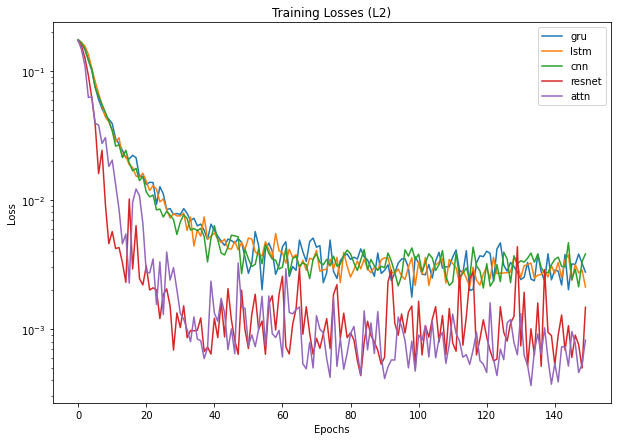

In [72]:
idx = 0

plt.figure(figsize=(10,7))
plt.plot(gru_results[idx])
plt.plot(lstm_results[idx])
plt.plot(cnn_results[idx])
plt.plot(resnet_results[idx])
plt.plot(attn_results[idx])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Training Losses (L2)")
plt.legend(["gru", "lstm", "cnn", "resnet", "attn"], loc="upper right")

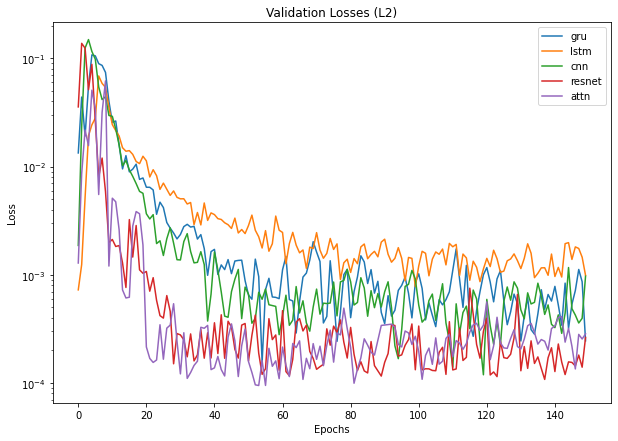

In [73]:
idx = 2

plt.figure(figsize=(10,7))
plt.plot(gru_results[idx])
plt.plot(lstm_results[idx])
plt.plot(cnn_results[idx])
plt.plot(resnet_results[idx])
plt.plot(attn_results[idx])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Validation Losses (L2)")
plt.legend(["gru", "lstm", "cnn", "resnet", "attn"], loc="upper right")

In [68]:
import matplotlib.ticker as mticker

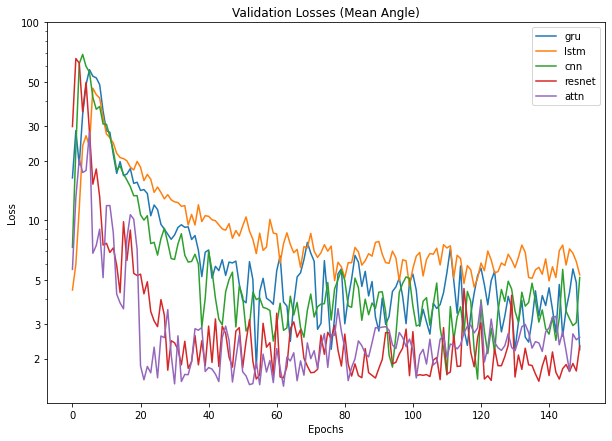

In [76]:
idx = 1

fig, ax = plt.subplots(figsize=(10,7))
ax.plot([x * 180 for x in gru_results[idx]])
ax.plot([x * 180 for x in lstm_results[idx]])
ax.plot([x * 180 for x in cnn_results[idx]])
ax.plot([x * 180 for x in resnet_results[idx]])
ax.plot([x * 180 for x in attn_results[idx]])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale('log')
ax.set_title("Validation Losses (Mean Angle)")
ax.legend(["gru", "lstm", "cnn", "resnet", "attn"], loc="upper right")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_yticks([2, 3, 5, 10, 20, 30, 50, 100])

In [ ]:
plt.plot(noaug_results[1])
plt.plot(cut_results[1])
plt.plot(awgn_results[1])
plt.plot(gru_results[1])
plt.xlabel("Epochs")
plt.ylabel("Mean Angle Error")
plt.title("Predicting Angles Together vs Seperately (SCADA 1)")
plt.legend(["noaug", "cut", "awgn", "all"], bbox_to_anchor=(1,1), loc="upper left")
plt.axis([0, 50, 0 , .04])

In [ ]:
loads1=[20.76947593688965,
 25.513036727905273,
 24.389039993286133,
 14.56358528137207,
 3.9245598316192627,
 13.908610343933105,
 12.729104042053223,
 21.16634750366211,
 16.966480255126953,
 20.829572677612305,
 16.553314208984375,
 12.26308822631836,
 13.12732982635498,
 12.120625495910645,
 10.881050109863281,
 7.353868007659912,
 7.464585781097412,
 10.48363971710205,
 9.197811126708984,
 3.7664573192596436,
 2.1193859577178955,
 2.8468472957611084,
 1.382707953453064,
 1.5108437538146973,
 1.718727707862854,
 1.9420124292373657,
 2.3332393169403076,
 1.3043898344039917,
 1.243025541305542,
 1.2916353940963745,
 1.3894659280776978,
 1.2388266324996948,
 1.782077431678772,
 1.8563101291656494,
 1.887804388999939,
 1.783848762512207,
 1.6194343566894531,
 3.088073492050171,
 2.2799036502838135,
 1.771976113319397,
 1.8743194341659546,
 1.6447467803955078,
 1.6258325576782227,
 1.8595281839370728,
 1.7280170917510986,
 2.0060627460479736,
 1.1982892751693726,
 1.4483202695846558,
 1.2498340606689453,
 1.1990635395050049,
 0.935013473033905,
 1.8192771673202515,
 1.3649299144744873,
 1.1650694608688354,
 2.2515320777893066,
 1.636359453201294,
 1.486596941947937,
 0.9383391737937927,
 0.9364563226699829,
 1.9605950117111206,
 3.4235191345214844,
 1.9974424839019775,
 2.1455626487731934,
 1.6670233011245728,
 2.1360268592834473,
 2.4867749214172363,
 2.736915111541748,
 1.5852854251861572,
 1.0491325855255127,
 0.9555380940437317,
 2.271923780441284,
 1.9718751907348633,
 1.6142507791519165,
 1.2736104726791382,
 1.586380124092102,
 2.2345054149627686,
 2.0785183906555176,
 1.302728533744812,
 0.937839686870575,
 1.1731847524642944,
 1.597582221031189,
 0.9612022638320923,
 0.9743358492851257,
 0.9474272727966309,
 1.2490441799163818,
 1.1463688611984253,
 1.2690123319625854,
 1.1194941997528076,
 0.9211004376411438,
 1.0224170684814453,
 0.949314296245575,
 1.5625015497207642,
 0.9266746640205383,
 1.1820980310440063,
 1.4758409261703491,
 1.2931554317474365,
 0.9412234425544739,
 1.5013054609298706,
 1.0509885549545288,
 0.9076401591300964]

In [ ]:
loads14 = [113.40666961669922,
 98.6358413696289,
 92.16695404052734,
 93.89134979248047,
 93.08482360839844,
 94.01512908935547,
 96.8314208984375,
 93.38842010498047,
 91.05752563476562,
 93.62814331054688,
 93.0281982421875,
 90.7175064086914,
 106.64373016357422,
 94.70916748046875,
 93.53018188476562,
 90.7057876586914,
 90.71583557128906,
 90.33683013916016,
 86.63447570800781,
 87.6590805053711,
 86.50321960449219,
 86.46022033691406,
 85.53292083740234,
 85.51774597167969,
 85.67818450927734,
 88.21336364746094,
 86.58519744873047,
 83.067626953125,
 84.28719329833984,
 83.5937728881836,
 84.73176574707031,
 86.36935424804688,
 84.40872192382812,
 82.3387680053711,
 81.76415252685547,
 82.7924575805664,
 83.05394744873047,
 83.34810638427734,
 84.10836029052734,
 83.3818588256836,
 85.225830078125,
 83.8253402709961,
 84.31026458740234,
 83.95003509521484,
 84.75933074951172,
 85.21197509765625,
 83.27616119384766,
 84.80321502685547,
 84.6070785522461,
 84.39447784423828,
 83.09471130371094,
 83.98709869384766,
 83.55381774902344,
 82.9478988647461,
 82.8241195678711,
 83.1274185180664,
 82.53296661376953,
 82.28174591064453,
 82.5969009399414,
 85.6344223022461,
 84.40013885498047,
 83.37957000732422,
 83.07867431640625,
 83.0792236328125,
 82.59563446044922,
 82.75960540771484,
 82.66078186035156,
 82.64547729492188,
 81.9713363647461,
 82.57807922363281,
 82.29306030273438,
 82.29933166503906,
 82.82366180419922,
 82.7708511352539,
 82.51446533203125,
 80.74446868896484,
 81.71956634521484,
 81.54293823242188,
 82.9375,
 83.56121063232422,
 83.3488540649414,
 81.85014343261719,
 83.00926971435547,
 82.04573822021484,
 82.84133911132812,
 83.12141418457031,
 84.43121337890625,
 81.53490447998047,
 80.81163787841797,
 81.32465362548828,
 81.08231353759766,
 82.27230072021484,
 81.62994384765625,
 81.34539794921875,
 81.95865631103516,
 81.44596099853516,
 82.8182373046875,
 84.33675384521484,
 82.76765441894531,
 82.47053527832031]

In [ ]:
plt.plot(np.stack(breakdowns, axis=0)[:,0])
plt.plot(loads1)
plt.xlabel("Epochs")
plt.ylabel("Mean Angle Error")
plt.title("Predicting Angles Together vs Seperately (SCADA 1)")
plt.legend(["Together", "Seperately"], bbox_to_anchor=(1,1), loc="upper left")
plt.axis([0, 90, 0 , 30])

In [ ]:
plt.plot(np.stack(breakdowns, axis=0)[:,-1])
plt.plot(loads14)
plt.xlabel("Epochs")
plt.ylabel("Mean Angle Error")
plt.title("Predicting Angles Together vs Seperately (SCADA 14)")
plt.legend(["Together", "Seperately"], bbox_to_anchor=(1,1), loc="upper left")
plt.axis([0, 100, 70 , 140])

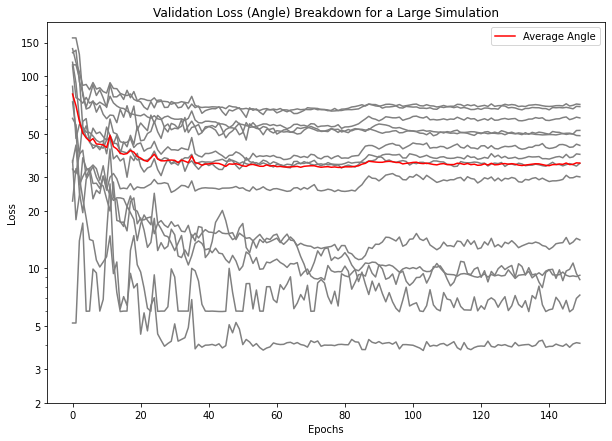

In [54]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(large_results[3], label='_Hidden', color="grey")
ax.plot(np.stack(large_results[3], axis=0).mean(1), label="Average Angle", color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Validation Loss (Angle) Breakdown for a Large Simulation")
ax.legend(loc="upper right")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_yticks([2, 3, 5, 10, 20, 30, 50, 100, 150])

In [ ]:
np.set_printoptions(threshold=sys.maxsize) 

In [ ]:
np.stack(breakdowns, axis=0).tolist()

In [ ]:
plt.plot(np.stack(breakdowns, axis=0))

In [ ]:
# running_naiive = 0
# loss_fn = L1AngLoss(2)
# full = PMUDataset("scatadata", "data", x1tfms=x1tfms, x2tfms=norm2, ytfms=rescale)
# loader = torch.utils.data.DataLoader(full, batch_size=bs, shuffle=False)

# for (x1, x2), labels in iter(validation_loader):
#     x1, x2, labels = x1.to(device), x2.to(device), labels.to(device) # puts the data on the GPU
# #     outputs = model((x1, x2)) # passes image to the model, and gets a ouput which is the class probability prediction
#     est = (x1[:,3].mean() + x1[:,9].mean()) / 2

#     val_loss = loss_fn(est, labels) # calculates val_loss from model predictions and true labels
#     running_naiive += val_loss.item()

# running_naiive / len(validation_loader)